# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc

from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

pd.options.display.max_columns = None

# Data Exploration

In [2]:
df = pd.read_csv('/kaggle/input/home-credit/application_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
df.shape

(307511, 122)

## Defining Target

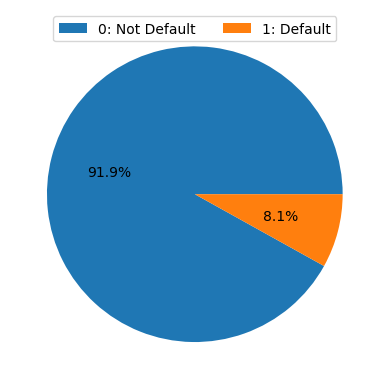

In [4]:
plt.pie(df['TARGET'].value_counts(), autopct='%.1f%%')
plt.legend(labels=['0: Not Default', '1: Default'], loc=9,  ncol=len(df.columns))
plt.show()

We can see above that there is a big difference in the target values, which means the target was imbalanced. Also, since we will create a credit scorecard that needs to know which borrower is good or not from the credit score, the higher credit score means the better borrower, so I'll change the value default to `0: bad` and not default to `1: good`.

In [5]:
df['TARGET'].replace([1,0], [0,1], inplace=True)

# General Cleaning

In [6]:
# Check duplicate value
df.duplicated('SK_ID_CURR').any()

False

In [7]:
# check columns that have missing value more than 70%
missing = df.isnull().mean()
missing[missing>0.7]

Series([], dtype: float64)

**Change columns with days count**

In [8]:
def days_to_year(df):
    df['DAYS_BIRTH'] = np.floor(-(df['DAYS_BIRTH'])/365)
    df['DAYS_LAST_PHONE_CHANGE'] = np.floor(-(df['DAYS_LAST_PHONE_CHANGE'])/365)
    df['DAYS_ID_PUBLISH'] = np.floor(-(df['DAYS_ID_PUBLISH'])/365)
    df['DAYS_EMPLOYED'] = np.floor(-(df['DAYS_EMPLOYED'])/365)
    df['DAYS_REGISTRATION'] = np.floor(-(df['DAYS_REGISTRATION'])/365)
    
    df.rename(columns = {'DAYS_BIRTH':'YEAR_BIRTH',
                         'DAYS_LAST_PHONE_CHANGE':'YEAR_LAST_PHONE_CHANGE', 
                         'DAYS_ID_PUBLISH':'YEAR_ID_PUBLISH',
                         'DAYS_EMPLOYED':'YEAR_EMPLOYED', 
                         'DAYS_REGISTRATION':'YEAR_REGISTRATION'}, inplace=True)
days_to_year(df)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,YEAR_BIRTH,YEAR_EMPLOYED,YEAR_REGISTRATION,YEAR_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEAR_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.0,1.0,9.0,5.0,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,45.0,3.0,3.0,0.0,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,52.0,0.0,11.0,6.0,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Split Data
Split data into 80:20, and because the data is imbalanced, I use the stratified split to keep the test set distribution the same as the actual data.

In [9]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)

# Feature Selection

Categorical Features: Chi Square Statistics <br>
Numerical Features: F-square Statistics

In [10]:
# devide the categorical and numerical columns
X_train_cat = X_train.select_dtypes(include='object').copy()
X_train_num = X_train.select_dtypes(include='number').copy()

### Categorical Features

In [11]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result['null'] = X_train_cat.isnull().sum().values
chi2_result['unique'] = X_train_cat.nunique().values
chi2_result.sort_values(by=['p-value', 'null', 'unique'], ignore_index=True, inplace=True)
chi2_result

,Feature,p-value,null,unique
0,NAME_CONTRACT_TYPE,0.000000,0,2
1,FLAG_OWN_CAR,0.000000,0,2
2,CODE_GENDER,0.000000,0,3
3,NAME_EDUCATION_TYPE,0.000000,0,5
4,NAME_FAMILY_STATUS,0.000000,0,6
5,NAME_HOUSING_TYPE,0.000000,0,6
6,NAME_INCOME_TYPE,0.000000,0,8
7,ORGANIZATION_TYPE,0.000000,0,58
8,OCCUPATION_TYPE,0.000000,76985,18
9,WALLSMATERIAL_MODE,0.000000,125202,7


I will select features that have:
- lowest p-value
- no null values 
- low unique value

From the table above I consider to select the top 7 features that meet the requirements. Let's check the distribution first.

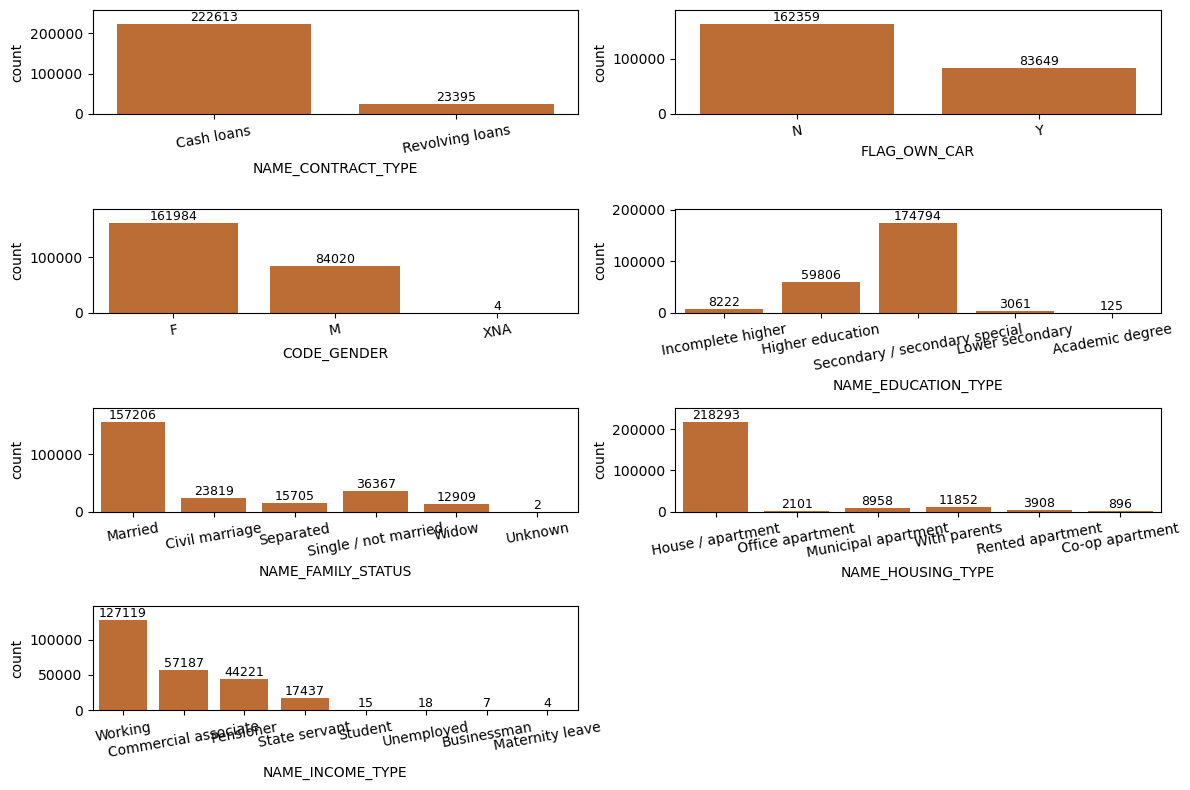

In [12]:
cat_selected = chi2_result[:7].Feature.to_list()
plt.figure(figsize=(12,8))
for i in range(0, len(cat_selected)):
    plt.subplot(4, 2, i+1)
    ax = sns.countplot(x=X_train[cat_selected[i]], color='chocolate')
    plt.xticks(rotation=10)
    plt.tight_layout()
    for container in ax.containers:
        ax.bar_label(container, fontsize=9, fmt='%.f')
        ax.set_ylim(top = ax.get_ylim()[1]*1.1)


We can see above, `NAME_HOUSING_TYPE` and `NAME_CONTRACT_TYPE` have one value that dominates the column so I will drop the columns.

In [13]:
cat_selected = [e for e in cat_selected if e not in ('NAME_HOUSING_TYPE','NAME_CONTRACT_TYPE')]
cat_selected

['FLAG_OWN_CAR',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE']

### Numerical Features

In [14]:
len(X_train.index)

246008

In [15]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num.fillna(X_train_num.median()), y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 
                                     'F-Score': F_statistic, 
                                     'p values': p_values.round(decimals=10), 
                                     'null': X_train_num.isnull().sum(), 
                                     'pct_null': X_train_num.isnull().mean()})
ANOVA_F_table.sort_values(['F-Score','p values', 'null'], ascending=[False, True, True], ignore_index=True, inplace=True)
ANOVA_F_table.head(30)

,Numerical_Feature,F-Score,p values,null,pct_null
0,EXT_SOURCE_2,6348.484037,0.0,533,0.002167
1,EXT_SOURCE_3,6085.676683,0.0,48833,0.198502
2,EXT_SOURCE_1,2531.988626,0.0,138774,0.564104
3,YEAR_BIRTH,1547.059844,0.0,0,0.000000
4,REGION_RATING_CLIENT_W_CITY,920.775165,0.0,0,0.000000
5,REGION_RATING_CLIENT,851.372545,0.0,0,0.000000
6,YEAR_LAST_PHONE_CHANGE,747.217495,0.0,1,0.000004
7,YEAR_ID_PUBLISH,632.483016,0.0,0,0.000000
8,REG_CITY_NOT_WORK_CITY,625.850232,0.0,0,0.000000
9,FLAG_EMP_PHONE,538.969281,0.0,0,0.000000


I will select features that have:
- high F-score
- low p-value
- no null values

From the table above, besides the columns with 0 null values, I consider selecting `EXT_SOURCE_2` and `EXT_SOURCE_3` because they have high F-scores. Also, `DAYS_LAST_PHONE_CHANGE` column with only 1 null value.

In [16]:
ANOVA_F_table = ANOVA_F_table[:30]
num_selected = ANOVA_F_table[(ANOVA_F_table['null'] < 10)].Numerical_Feature.to_list()
num_selected[:0] = ['EXT_SOURCE_2', 'EXT_SOURCE_3']
num_selected
# ANOVA_F_table[ANOVA_F_table[nu]]

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEAR_BIRTH',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'YEAR_LAST_PHONE_CHANGE',
 'YEAR_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_EMP_PHONE',
 'FLAG_DOCUMENT_3',
 'YEAR_EMPLOYED',
 'REG_CITY_NOT_LIVE_CITY',
 'YEAR_REGISTRATION',
 'REGION_POPULATION_RELATIVE',
 'LIVE_CITY_NOT_WORK_CITY',
 'AMT_CREDIT',
 'FLAG_DOCUMENT_6',
 'FLAG_WORK_PHONE']

<AxesSubplot:>

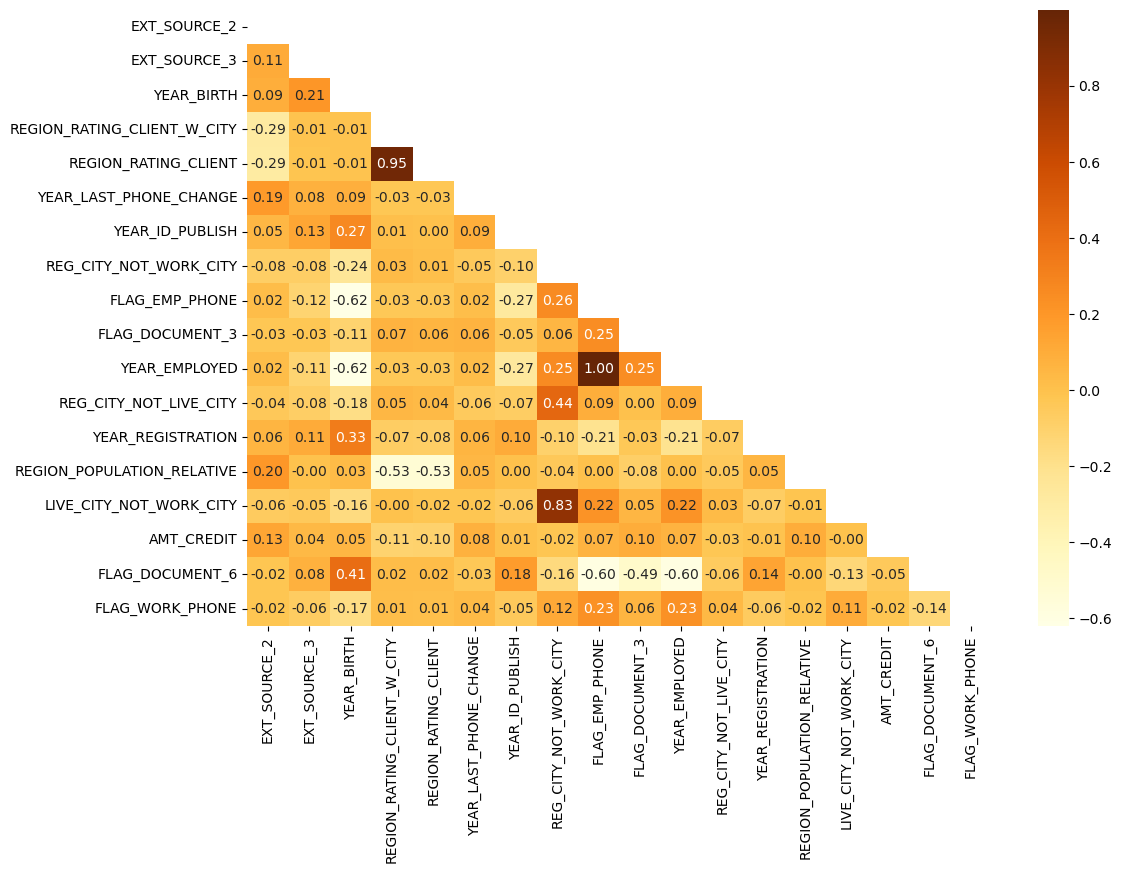

In [17]:
plt.figure(figsize=(12,8))
corr = X_train[num_selected].corr()
# tr = corrmat[abs(corrmat) <= 0.7]
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='YlOrBr')

We saw above that some columns have a correlation of more than 70% which indicates the presence of multicollinearity. So, I will drop the following columns to avoid multicollinearity.
- FLAG_EMP_PHONE
- REGION_RATING_CLIENT_W_CITY
- REG_CITY_NOT_WORK_CITY

In [18]:
num_selected = [e for e in num_selected if e not in ('FLAG_EMP_PHONE','REGION_RATING_CLIENT_W_CITY','REG_CITY_NOT_WORK_CITY')]
num_selected

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEAR_BIRTH',
 'REGION_RATING_CLIENT',
 'YEAR_LAST_PHONE_CHANGE',
 'YEAR_ID_PUBLISH',
 'FLAG_DOCUMENT_3',
 'YEAR_EMPLOYED',
 'REG_CITY_NOT_LIVE_CITY',
 'YEAR_REGISTRATION',
 'REGION_POPULATION_RELATIVE',
 'LIVE_CITY_NOT_WORK_CITY',
 'AMT_CREDIT',
 'FLAG_DOCUMENT_6',
 'FLAG_WORK_PHONE']

In [19]:
selected_cols = cat_selected + num_selected
X_train = X_train[selected_cols]
X_test = X_test[selected_cols]

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 293082 to 108255
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FLAG_OWN_CAR                246008 non-null  object 
 1   CODE_GENDER                 246008 non-null  object 
 2   NAME_EDUCATION_TYPE         246008 non-null  object 
 3   NAME_FAMILY_STATUS          246008 non-null  object 
 4   NAME_INCOME_TYPE            246008 non-null  object 
 5   EXT_SOURCE_2                245475 non-null  float64
 6   EXT_SOURCE_3                197175 non-null  float64
 7   YEAR_BIRTH                  246008 non-null  float64
 8   REGION_RATING_CLIENT        246008 non-null  int64  
 9   YEAR_LAST_PHONE_CHANGE      246007 non-null  float64
 10  YEAR_ID_PUBLISH             246008 non-null  float64
 11  FLAG_DOCUMENT_3             246008 non-null  int64  
 12  YEAR_EMPLOYED               246008 non-null  float64
 13  REG_CITY_

In [21]:
# X_train['EXT_SOURCE_2'].fillna(X_train['EXT_SOURCE_2'].median(), inplace=True)
# X_train['EXT_SOURCE_3'].fillna(X_train['EXT_SOURCE_3'].median(), inplace=True)
# X_train['DAYS_LAST_PHONE_CHANGE'].fillna(X_train['DAYS_LAST_PHONE_CHANGE'].median(), inplace=True)
X_train.isnull().sum()

FLAG_OWN_CAR                      0
CODE_GENDER                       0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_INCOME_TYPE                  0
EXT_SOURCE_2                    533
EXT_SOURCE_3                  48833
YEAR_BIRTH                        0
REGION_RATING_CLIENT              0
YEAR_LAST_PHONE_CHANGE            1
YEAR_ID_PUBLISH                   0
FLAG_DOCUMENT_3                   0
YEAR_EMPLOYED                     0
REG_CITY_NOT_LIVE_CITY            0
YEAR_REGISTRATION                 0
REGION_POPULATION_RELATIVE        0
LIVE_CITY_NOT_WORK_CITY           0
AMT_CREDIT                        0
FLAG_DOCUMENT_6                   0
FLAG_WORK_PHONE                   0
dtype: int64

# WoE Binning / Feature Engineering

In [22]:
pd.DataFrame({'Information Value': ['< 0.02', '0.02 - 0.1', '0.1 - 0.3', '0.3 - 0.5', '> 0.5'],
              'Variable Predictiveness' : ['Not useful for prediction','Weak predictive power','Medium Predictive Power',
                                           'Strong predictive power','suspicious predictive power']})

,Information Value,Variable Predictiveness
0,< 0.02,Not useful for prediction
1,0.02 - 0.1,Weak predictive power
2,0.1 - 0.3,Medium Predictive Power
3,0.3 - 0.5,Strong predictive power
4,> 0.5,suspicious predictive power


In [23]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prep = X_train.copy()
y_train_prep = y_train.copy()
X_test_prep = X_test.copy()
y_test_prep = y_test.copy()

## Categorical Features

In [24]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_cat(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = df.groupby(cat_variable_name, as_index = False).agg({df.columns[1]: ['count','sum']})
    df.columns = [cat_variable_name, 'n_obs', 'n_good']
    df.insert(1, 'tot_obs', df.n_obs.sum())
    df.insert(3, 'pct_obs', df.n_obs/df.tot_obs,1)
    df['n_bad'] = df['n_obs'] - df['n_good']
    df['pct_good'] = df['n_good'] / df['n_good'].sum()
    df['pct_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['pct_good'] / df['pct_bad'])
    df = df.sort_values(['WoE'])
    df['IV'] = (df['pct_good'] - df['pct_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [25]:
# We set the default style of the graphs to the seaborn style. 
# sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(15, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

### FLAG_OWN_CAR

In [26]:
df_temp = woe_cat(X_train_prep, 'FLAG_OWN_CAR', y_train_prep)
df_temp

,FLAG_OWN_CAR,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,IV
0,N,246008,162359,0.659974,148568,13791,0.65695,0.694411,-0.055455,0.006409
1,Y,246008,83649,0.340026,77580,6069,0.34305,0.305589,0.115634,0.006409


This feature is not useful for prediction because the information value is so low.

### CODE_GENDER

In [27]:
df_temp = woe_cat(X_train_prep, 'CODE_GENDER', y_train_prep)
df_temp

,CODE_GENDER,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,IV
1,M,246008,84020,0.341534,75529,8491,0.333980,0.427543,-0.246972,inf
0,F,246008,161984,0.658450,150615,11369,0.666002,0.572457,0.151355,inf
2,XNA,246008,4,0.000016,4,0,0.000018,0.000000,inf,inf


Here we found a problem that `XNA` has no bad label which leads to `inf` value. So, I will change XNA to F as it has the highest number of observation.

In [28]:
X_train_prep['CODE_GENDER'].replace('XNA', 'F', inplace=True)
df_temp = woe_cat(X_train_prep, 'CODE_GENDER', y_train_prep)
df_temp

,CODE_GENDER,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,IV
1,M,246008,84020,0.341534,75529,8491,0.33398,0.427543,-0.246972,0.037271
0,F,246008,161988,0.658466,150619,11369,0.66602,0.572457,0.151381,0.037271


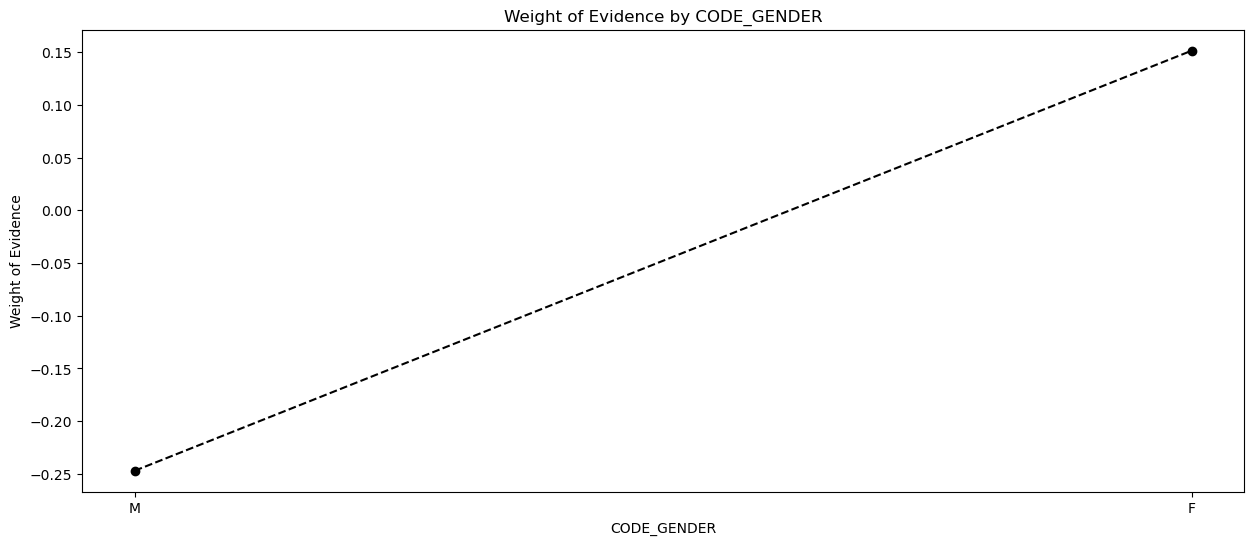

In [29]:
plot_woe(df_temp)

### NAME_EDUCATION_TYPE

In [30]:
df_temp = woe_cat(X_train_prep, 'NAME_EDUCATION_TYPE', y_train_prep)
df_temp

,NAME_EDUCATION_TYPE,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,IV
3,Lower secondary,246008,3061,0.012443,2722,339,0.012036,0.017069,-0.349360,0.049484
4,Secondary / secondary special,246008,174794,0.710522,159200,15594,0.703964,0.785196,-0.109207,0.049484
2,Incomplete higher,246008,8222,0.033422,7518,704,0.033244,0.035448,-0.064205,0.049484
1,Higher education,246008,59806,0.243106,56586,3220,0.250217,0.162135,0.433898,0.049484
0,Academic degree,246008,125,0.000508,122,3,0.000539,0.000151,1.272927,0.049484


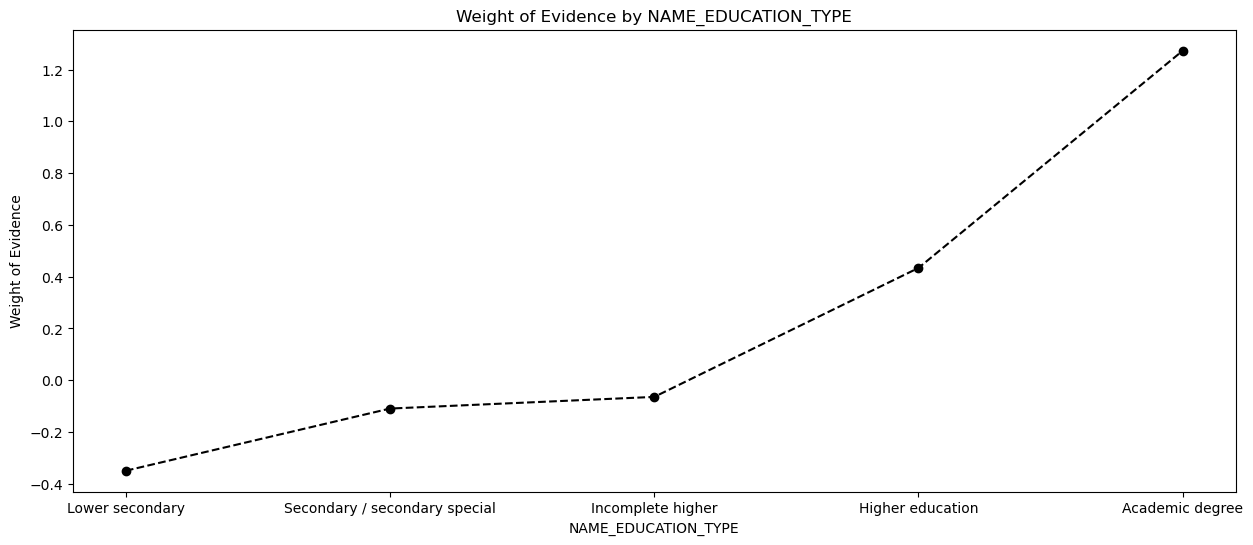

In [31]:
plot_woe(df_temp)

### NAME_FAMILY_STATUS

In [32]:
df_temp = woe_cat(X_train_prep, 'NAME_FAMILY_STATUS', y_train_prep)
df_temp

,NAME_FAMILY_STATUS,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,IV
0,Civil marriage,246008,23819,0.096822,21384,2435,0.094558,0.122608,-0.259786,inf
3,Single / not married,246008,36367,0.147829,32778,3589,0.144940,0.180715,-0.220598,inf
2,Separated,246008,15705,0.063839,14418,1287,0.063755,0.064804,-0.016318,inf
1,Married,246008,157206,0.639028,145404,11802,0.642959,0.594260,0.078765,inf
5,Widow,246008,12909,0.052474,12162,747,0.053779,0.037613,0.357524,inf
4,Unknown,246008,2,0.000008,2,0,0.000009,0.000000,inf,inf


Here we found a problem that `Unknown` has no bad label which leads to `inf` value. So, I will change Unknown to Married as it has the highest number of observation.

In [33]:
X_train_prep['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)

In [34]:
df_temp = woe_cat(X_train_prep, 'NAME_FAMILY_STATUS', y_train_prep)
df_temp

,NAME_FAMILY_STATUS,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,IV
0,Civil marriage,246008,23819,0.096822,21384,2435,0.094558,0.122608,-0.259786,0.024813
3,Single / not married,246008,36367,0.147829,32778,3589,0.144940,0.180715,-0.220598,0.024813
2,Separated,246008,15705,0.063839,14418,1287,0.063755,0.064804,-0.016318,0.024813
1,Married,246008,157208,0.639036,145406,11802,0.642968,0.594260,0.078779,0.024813
4,Widow,246008,12909,0.052474,12162,747,0.053779,0.037613,0.357524,0.024813


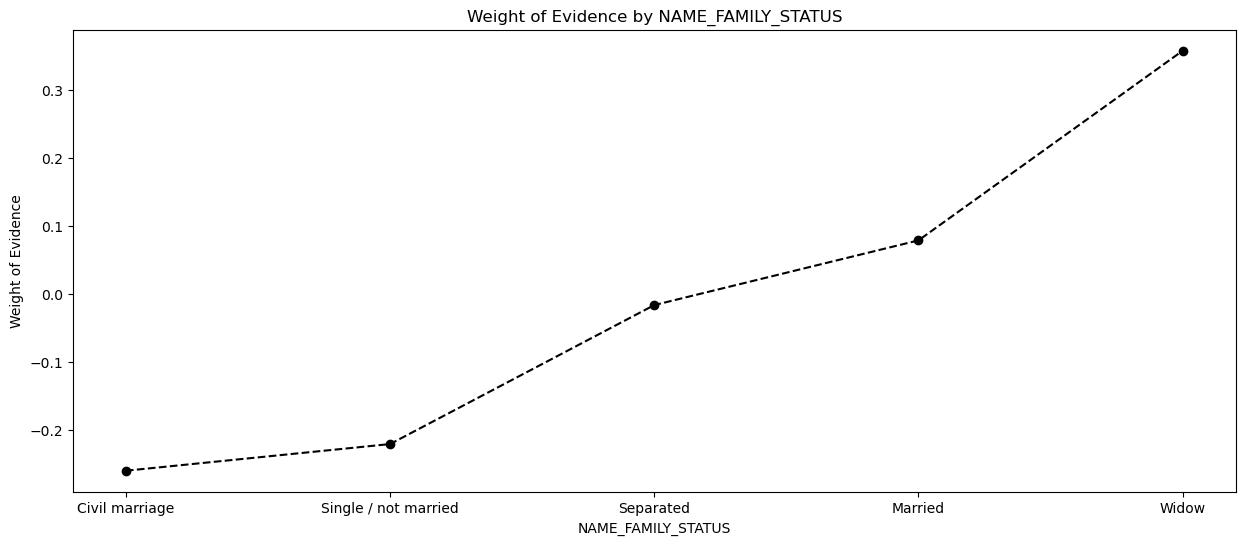

In [35]:
plot_woe(df_temp)

### NAME_INCOME_TYPE

In [36]:
df_temp = woe_cat(X_train_prep, 'NAME_INCOME_TYPE', y_train_prep)
df_temp

,NAME_INCOME_TYPE,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,IV
2,Maternity leave,246008,4,0.000016,2,2,0.000009,0.000101,-2.432482,inf
6,Unemployed,246008,18,0.000073,11,7,0.000049,0.000352,-1.980497,inf
7,Working,246008,127119,0.516727,114940,12179,0.508251,0.613243,-0.187785,inf
1,Commercial associate,246008,57187,0.232460,52890,4297,0.233873,0.216365,0.077815,inf
4,State servant,246008,17437,0.070880,16422,1015,0.072616,0.051108,0.351251,inf
3,Pensioner,246008,44221,0.179754,41861,2360,0.185104,0.118832,0.443211,inf
0,Businessman,246008,7,0.000028,7,0,0.000031,0.000000,inf,inf
5,Student,246008,15,0.000061,15,0,0.000066,0.000000,inf,inf


Here we found a problem that `Businessman` and `Student` have no bad label which leads to `inf` value. Beside, So, I will change these value into:
- Businessman -> Commercial associate
- Student -> Unemployed

In [37]:
X_train_prep['NAME_INCOME_TYPE'].replace('Businessman', 'Commercial associate', inplace=True)
X_train_prep['NAME_INCOME_TYPE'].replace('Student', 'Unemployed', inplace=True)

In [38]:
df_temp = woe_cat(X_train_prep, 'NAME_INCOME_TYPE', y_train_prep)
df_temp

,NAME_INCOME_TYPE,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,IV
1,Maternity leave,246008,4,0.000016,2,2,0.000009,0.000101,-2.432482,0.0585
4,Unemployed,246008,33,0.000134,26,7,0.000115,0.000352,-1.120296,0.0585
5,Working,246008,127119,0.516727,114940,12179,0.508251,0.613243,-0.187785,0.0585
0,Commercial associate,246008,57194,0.232488,52897,4297,0.233904,0.216365,0.077948,0.0585
3,State servant,246008,17437,0.070880,16422,1015,0.072616,0.051108,0.351251,0.0585
2,Pensioner,246008,44221,0.179754,41861,2360,0.185104,0.118832,0.443211,0.0585


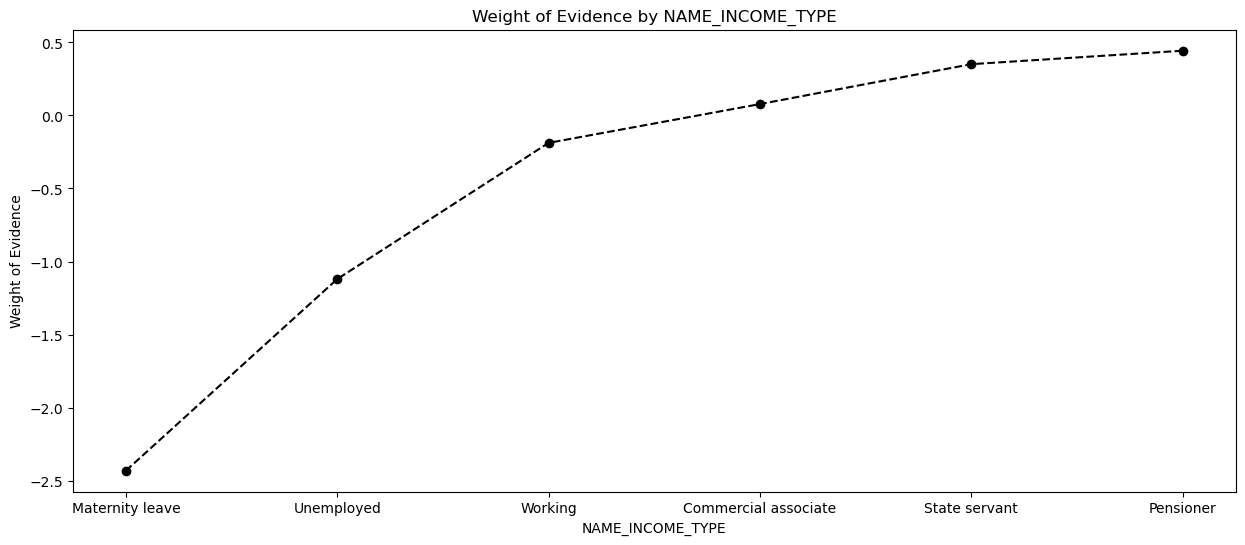

In [39]:
plot_woe(df_temp)

## Numerical Features

In [40]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_num(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = df.groupby(cat_variable_name, as_index = False).agg({df.columns[1]: ['count','sum']})
    df.columns = [cat_variable_name, 'n_obs', 'n_good']
    df.insert(1, 'tot_obs', df.n_obs.sum())
    df.insert(3, 'pct_obs', df.n_obs/df.tot_obs,1)
    df['n_bad'] = df['n_obs'] - df['n_good']
    df['pct_good'] = df['n_good'] / df['n_good'].sum()
    df['pct_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['pct_good'] / df['pct_bad'])
    df['diff_WoE'] = df['WoE'].diff().abs()
#     df = df.sort_values(['WoE'])
    df['IV'] = (df['pct_good'] - df['pct_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [41]:
def plot_dist(df):
    plt.figure(figsize=(15, 4))
    sns.kdeplot(x=X_train_prep[df], color='k')
    plt.title(str('Distribution of ' + df))

### EXT_SOURCE_2

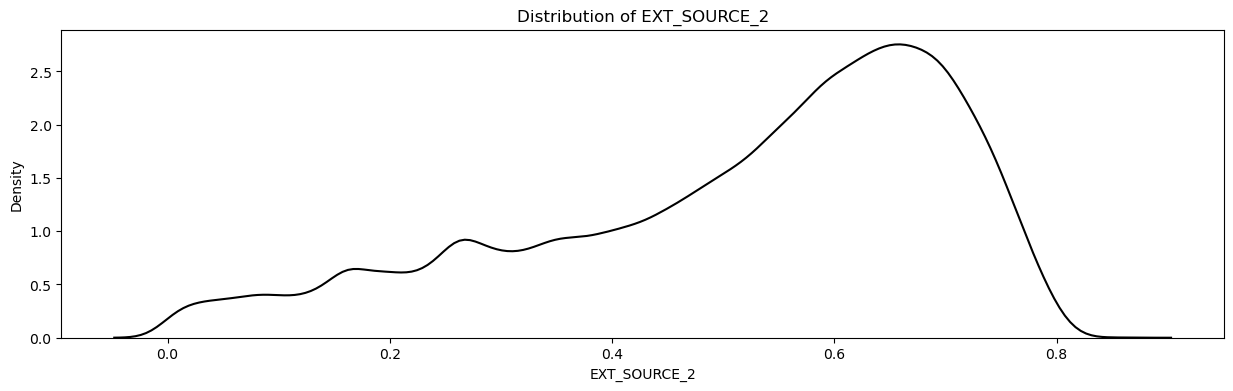

In [42]:
plot_dist('EXT_SOURCE_2')

In [43]:
# fine-classing
X_train_prep['EXT_SOURCE_2_class'] = pd.cut(X_train_prep['EXT_SOURCE_2'], 10)
# Process 'EXT_SOURCE_2_class' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_num(X_train_prep, 'EXT_SOURCE_2_class', y_train_prep)
df_temp

,EXT_SOURCE_2_class,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,"(-0.000855, 0.0855]",245475,7613,0.031013,5794,1819,0.025676,0.091785,-1.273890,NaN,0.309805
1,"(0.0855, 0.171]",245475,10402,0.042375,8662,1740,0.038386,0.087799,-0.827365,0.446525,0.309805
2,"(0.171, 0.256]",245475,13406,0.054612,11584,1822,0.051335,0.091937,-0.582735,0.244630,0.309805
3,"(0.256, 0.342]",245475,18279,0.074464,16157,2122,0.071600,0.107074,-0.402431,0.180304,0.309805
4,"(0.342, 0.427]",245475,20732,0.084457,18665,2067,0.082714,0.104299,-0.231874,0.170557,0.309805
5,"(0.427, 0.513]",245475,28203,0.114892,25804,2399,0.114351,0.121052,-0.056948,0.174926,0.309805
6,"(0.513, 0.598]",245475,42762,0.174201,39721,3041,0.176024,0.153446,0.137268,0.194216,0.309805
7,"(0.598, 0.684]",245475,56207,0.228972,53116,3091,0.235384,0.155969,0.411558,0.274290,0.309805
8,"(0.684, 0.769]",245475,42721,0.174034,41111,1610,0.182184,0.081239,0.807616,0.396058,0.309805
9,"(0.769, 0.855]",245475,5150,0.020980,5043,107,0.022348,0.005399,1.420502,0.612886,0.309805


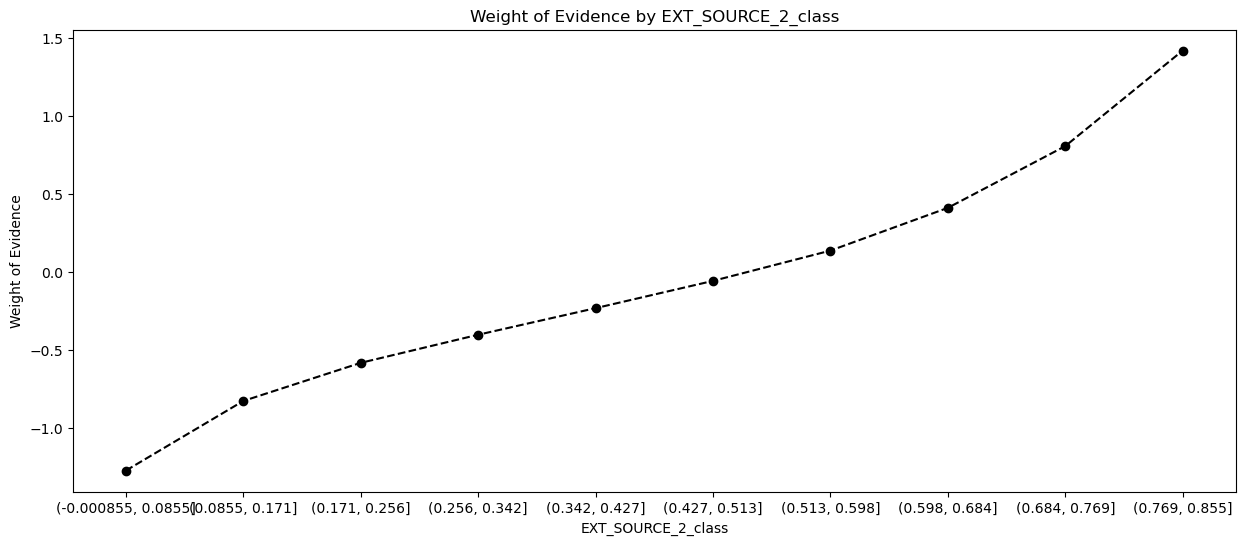

In [44]:
plot_woe(df_temp)

### EXT_SOURCE_3

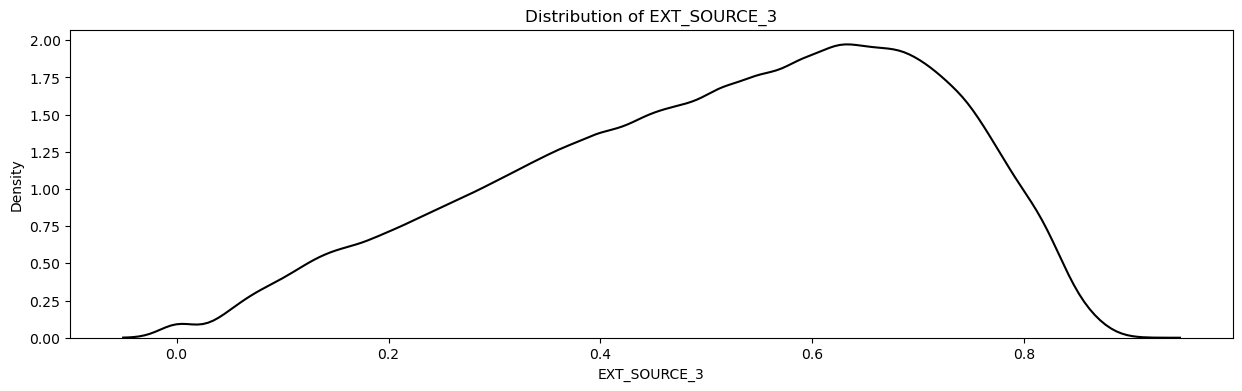

In [45]:
plot_dist('EXT_SOURCE_3')

In [46]:
X_train_prep['EXT_SOURCE_3_class'] = pd.cut(X_train_prep['EXT_SOURCE_3'], 10)

df_temp = woe_num(X_train_prep, 'EXT_SOURCE_3_class', y_train_prep)
df_temp

,EXT_SOURCE_3_class,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,"(-0.000368, 0.0901]",197175,3542,0.017964,2604,938,0.014318,0.061299,-1.454271,NaN,0.416366
1,"(0.0901, 0.18]",197175,9277,0.047050,7437,1840,0.040891,0.120246,-1.078623,0.375648,0.416366
2,"(0.18, 0.269]",197175,13923,0.070612,11788,2135,0.064814,0.139524,-0.766710,0.311913,0.416366
3,"(0.269, 0.359]",197175,19380,0.098288,17175,2205,0.094434,0.144099,-0.422598,0.344112,0.416366
4,"(0.359, 0.448]",197175,24369,0.123591,22194,2175,0.122030,0.142138,-0.152532,0.270066,0.416366
5,"(0.448, 0.538]",197175,28630,0.145201,26717,1913,0.146899,0.125016,0.161302,0.313834,0.416366
6,"(0.538, 0.627]",197175,32869,0.166700,31199,1670,0.171543,0.109136,0.452237,0.290935,0.416366
7,"(0.627, 0.717]",197175,34349,0.174206,32923,1426,0.181022,0.093190,0.663973,0.211736,0.416366
8,"(0.717, 0.806]",197175,24638,0.124955,23823,815,0.130987,0.053261,0.899894,0.235920,0.416366
9,"(0.806, 0.896]",197175,6198,0.031434,6013,185,0.033062,0.012090,1.005998,0.106105,0.416366


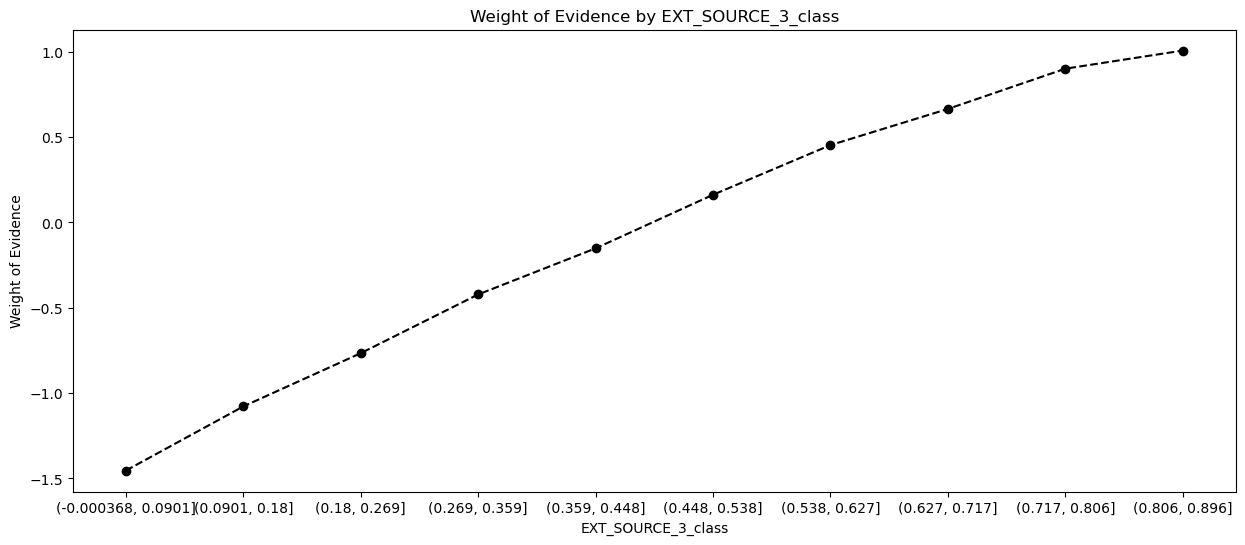

In [47]:
plot_woe(df_temp)

### YEAR_BIRTH

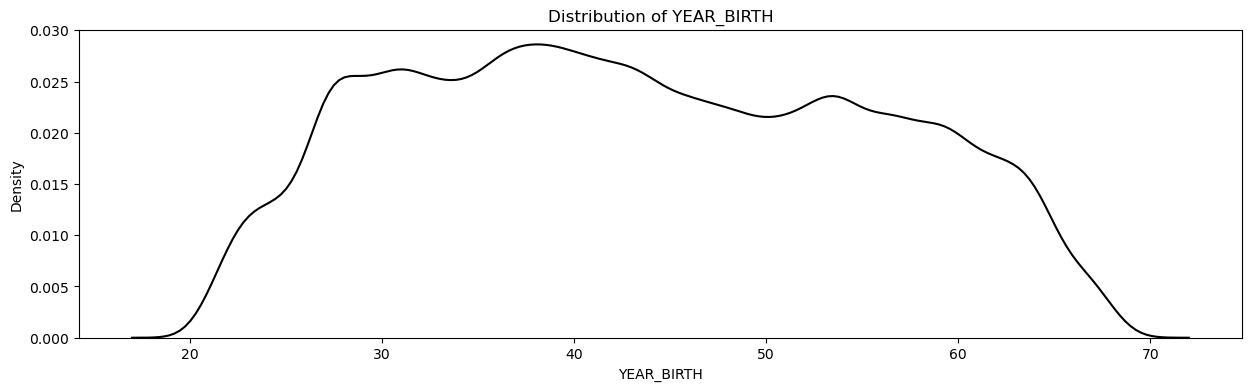

In [48]:
plot_dist('YEAR_BIRTH')

In [49]:
X_train_prep['YEAR_BIRTH_class'] = pd.cut(X_train_prep['YEAR_BIRTH'], 7)
# X_train_prep['YEAR_BIRTH'] = np.where(X_train_prep['YEAR_BIRTH'] < 21, 21, X_train_prep['YEAR_BIRTH'])
# X_train_prep['YEAR_BIRTH'] = np.where(X_train_prep['YEAR_BIRTH'] > 68, 68, X_train_prep['YEAR_BIRTH'])

df_temp = woe_num(X_train_prep, 'YEAR_BIRTH_class', y_train_prep)
df_temp

,YEAR_BIRTH_class,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,"(19.951, 27.0]",246008,23458,0.095355,20740,2718,0.091710,0.136858,-0.400314,NaN,0.084129
1,"(27.0, 34.0]",246008,44076,0.179165,39411,4665,0.174271,0.234894,-0.298525,0.101789,0.084129
2,"(34.0, 41.0]",246008,47899,0.194705,43705,4194,0.193258,0.211178,-0.088674,0.209850,0.084129
3,"(41.0, 48.0]",246008,42338,0.172100,39193,3145,0.173307,0.158359,0.090202,0.178877,0.084129
4,"(48.0, 55.0]",246008,38565,0.156763,36002,2563,0.159197,0.129053,0.209914,0.119712,0.084129
5,"(55.0, 62.0]",246008,34915,0.141926,33004,1911,0.145940,0.096224,0.416520,0.206606,0.084129
6,"(62.0, 69.0]",246008,14757,0.059986,14093,664,0.062318,0.033434,0.622669,0.206149,0.084129


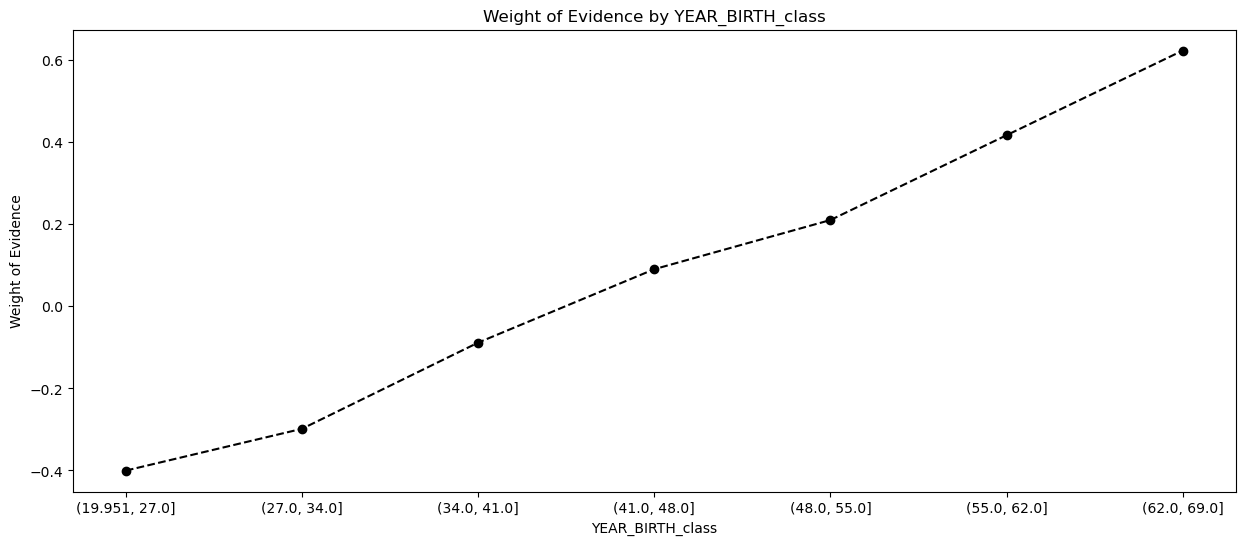

In [50]:
plot_woe(df_temp)

### REGION_RATING_CLIENT

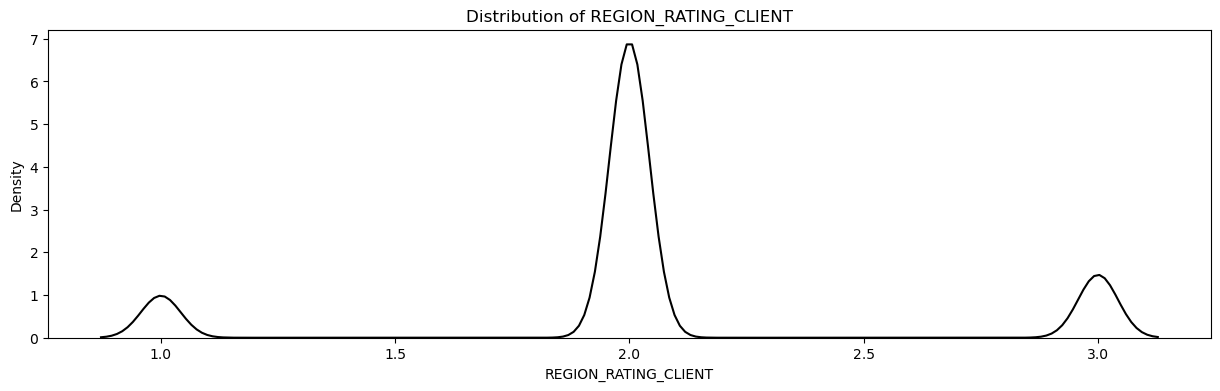

In [51]:
plot_dist('REGION_RATING_CLIENT')

In [52]:
df_temp = woe_num(X_train_prep, 'REGION_RATING_CLIENT', y_train_prep)
df_temp

,REGION_RATING_CLIENT,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,1,246008,25788,0.104826,24542,1246,0.108522,0.062739,0.547966,NaN,0.048016
1,2,246008,181613,0.738240,167283,14330,0.739706,0.721551,0.024850,0.523116,0.048016
2,3,246008,38607,0.156934,34323,4284,0.151772,0.215710,-0.351553,0.376403,0.048016


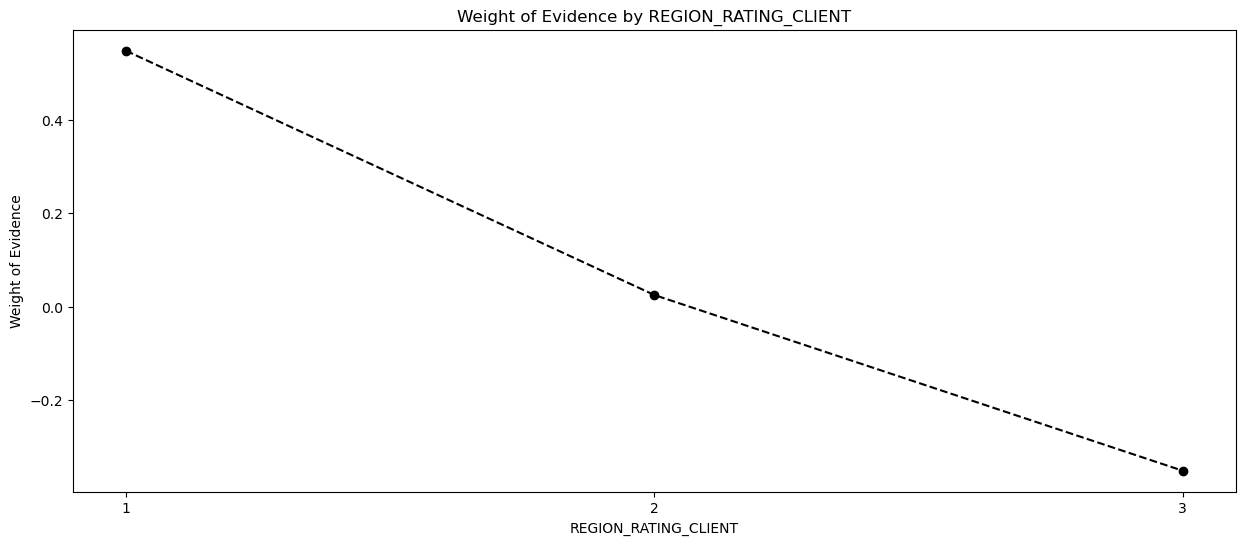

In [53]:
plot_woe(df_temp)

### YEAR_LAST_PHONE_CHANGE

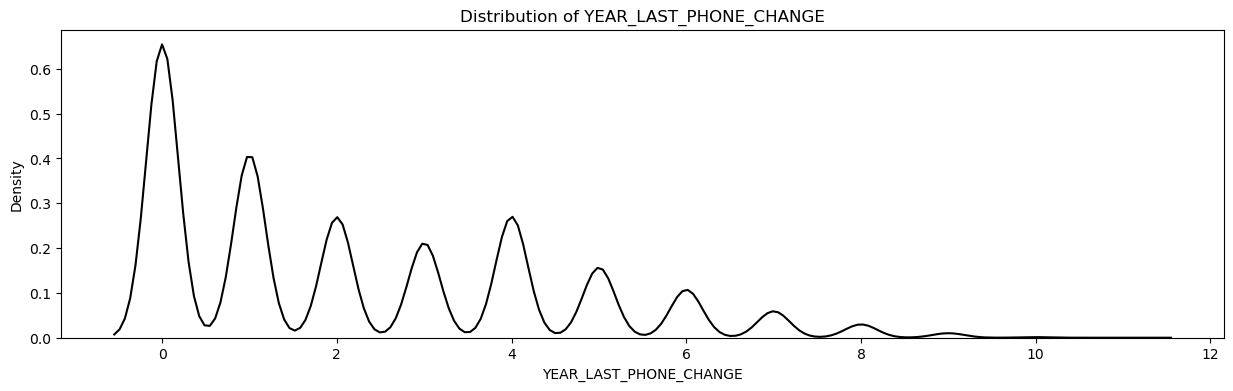

In [54]:
plot_dist('YEAR_LAST_PHONE_CHANGE')

In [55]:
X_train_prep['YEAR_LAST_PHONE_CHANGE'].fillna(X_train_prep['YEAR_LAST_PHONE_CHANGE'].median(), inplace=True)

df_temp = woe_num(X_train_prep, 'YEAR_LAST_PHONE_CHANGE', y_train_prep)
df_temp

,YEAR_LAST_PHONE_CHANGE,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,-0.0,246008,73939,0.300555,66874,7065,0.295709,0.355740,-0.184825,NaN,0.04539
1,1.0,246008,46158,0.187628,41887,4271,0.185219,0.215055,-0.149354,0.035470,0.04539
2,2.0,246008,30387,0.123520,27886,2501,0.123309,0.125932,-0.021048,0.128307,0.04539
3,3.0,246008,23880,0.097070,22151,1729,0.097949,0.087059,0.117857,0.138905,0.04539
4,4.0,246008,30526,0.124085,28543,1983,0.126214,0.099849,0.234319,0.116461,0.04539
5,5.0,246008,17682,0.071876,16622,1060,0.073501,0.053374,0.319976,0.085657,0.04539
6,6.0,246008,12096,0.049169,11433,663,0.050555,0.033384,0.415002,0.095026,0.04539
7,7.0,246008,6673,0.027125,6308,365,0.027893,0.018379,0.417195,0.002192,0.04539
8,8.0,246008,3354,0.013634,3200,154,0.014150,0.007754,0.601471,0.184277,0.04539
9,9.0,246008,1138,0.004626,1079,59,0.004771,0.002971,0.473771,0.127701,0.04539


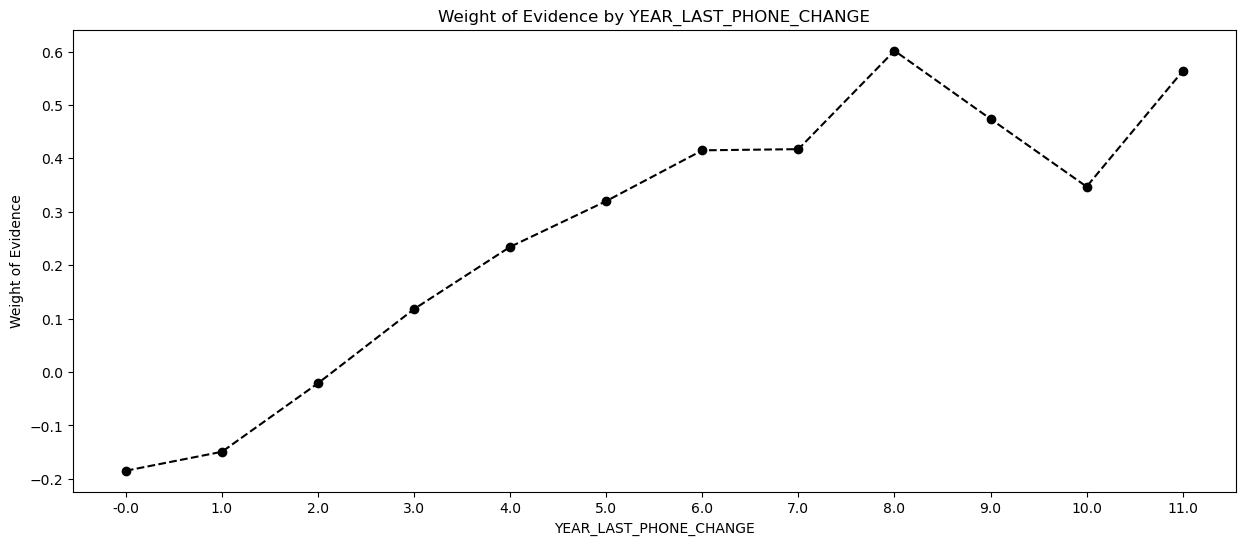

In [56]:
plot_woe(df_temp)

### YEAR_ID_PUBLISH

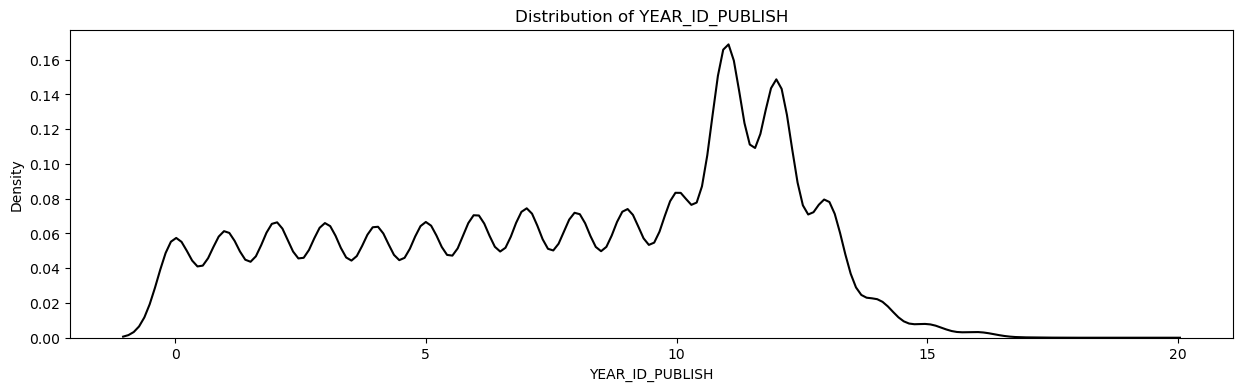

In [57]:
plot_dist('YEAR_ID_PUBLISH')

In [58]:
X_train_prep['YEAR_ID_PUBLISH'] = np.where(X_train_prep['YEAR_ID_PUBLISH'] > 16, 17, X_train_prep['YEAR_ID_PUBLISH'])

df_temp = woe_num(X_train_prep, 'YEAR_ID_PUBLISH', y_train_prep)
df_temp

,YEAR_ID_PUBLISH,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,0.0,246008,12027,0.048889,10776,1251,0.047650,0.062991,-0.279104,NaN,0.038992
1,1.0,246008,12704,0.051641,11427,1277,0.050529,0.064300,-0.241017,0.038087,0.038992
2,2.0,246008,13797,0.056084,12453,1344,0.055066,0.067674,-0.206171,0.034846,0.038992
3,3.0,246008,13653,0.055498,12365,1288,0.054677,0.064854,-0.170703,0.035468,0.038992
4,4.0,246008,13279,0.053978,12010,1269,0.053107,0.063897,-0.184972,0.014269,0.038992
5,5.0,246008,13767,0.055962,12561,1206,0.055543,0.060725,-0.089194,0.095777,0.038992
6,6.0,246008,14691,0.059718,13345,1346,0.059010,0.067774,-0.138477,0.049283,0.038992
7,7.0,246008,15424,0.062697,14068,1356,0.062207,0.068278,-0.093118,0.045359,0.038992
8,8.0,246008,14913,0.060620,13701,1212,0.060584,0.061027,-0.007285,0.085833,0.038992
9,9.0,246008,15312,0.062242,14145,1167,0.062548,0.058761,0.062443,0.069728,0.038992


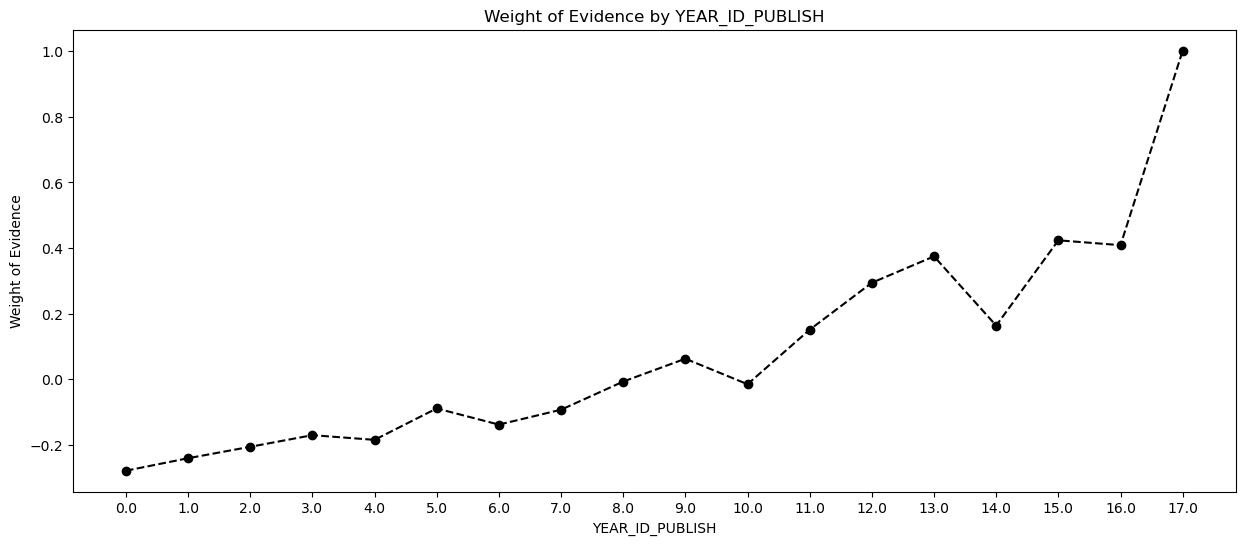

In [59]:
plot_woe(df_temp)

### FLAG_DOCUMENT_3

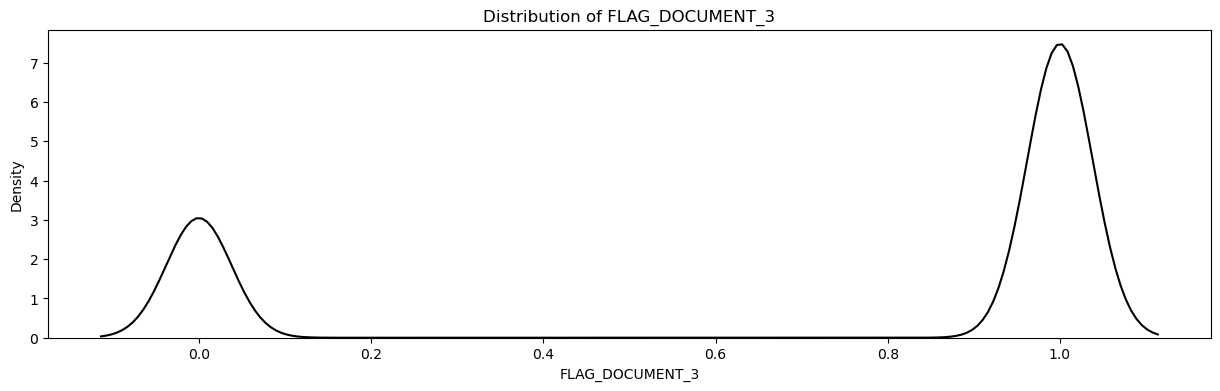

In [60]:
plot_dist('FLAG_DOCUMENT_3')

In [61]:
df_temp = woe_num(X_train_prep, 'FLAG_DOCUMENT_3', y_train_prep)
df_temp

,FLAG_DOCUMENT_3,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,0,246008,71201,0.289426,66844,4357,0.295576,0.219386,0.298096,NaN,0.030537
1,1,246008,174807,0.710574,159304,15503,0.704424,0.780614,-0.102701,0.400797,0.030537


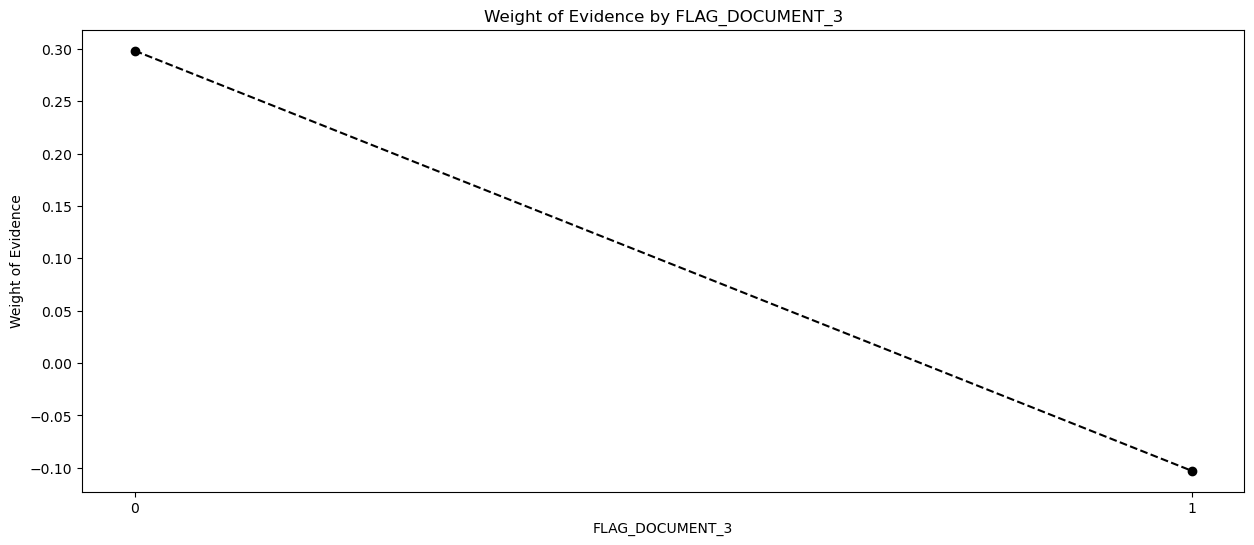

In [62]:
plot_woe(df_temp)

### YEAR_EMPLOYED

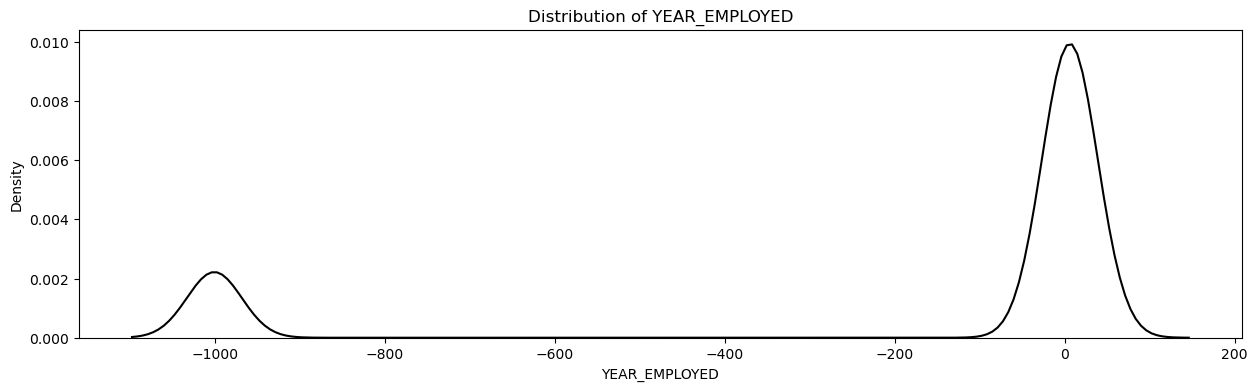

In [63]:
plot_dist('YEAR_EMPLOYED')

In [64]:
df_temp = woe_num(X_train_prep, 'YEAR_EMPLOYED', y_train_prep)
df_temp

,YEAR_EMPLOYED,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,-1001.0,246008,44230,0.179791,41863,2367,0.185113,0.119184,0.440297,NaN,inf
1,0.0,246008,22264,0.090501,19803,2461,0.087567,0.123917,-0.347216,0.787513,inf
2,1.0,246008,25429,0.103367,22523,2906,0.099594,0.146324,-0.384723,0.037506,inf
3,2.0,246008,23803,0.096757,21265,2538,0.094031,0.127795,-0.306796,0.077927,inf
4,3.0,246008,20129,0.081823,18078,2051,0.079939,0.103273,-0.256114,0.050682,inf
5,4.0,246008,17420,0.070811,15842,1578,0.070051,0.079456,-0.125976,0.130138,inf
6,5.0,246008,13019,0.052921,11940,1079,0.052797,0.054330,-0.028623,0.097353,inf
7,6.0,246008,12063,0.049035,11120,943,0.049171,0.047482,0.034952,0.063575,inf
8,7.0,246008,10516,0.042747,9741,775,0.043074,0.039023,0.098754,0.063802,inf
9,8.0,246008,9175,0.037296,8558,617,0.037842,0.031067,0.197271,0.098517,inf


This column has a weird distribution. We can see that there is -1000 with lots frequency. So, I will not use this column.

### REG_CITY_NOT_LIVE_CITY

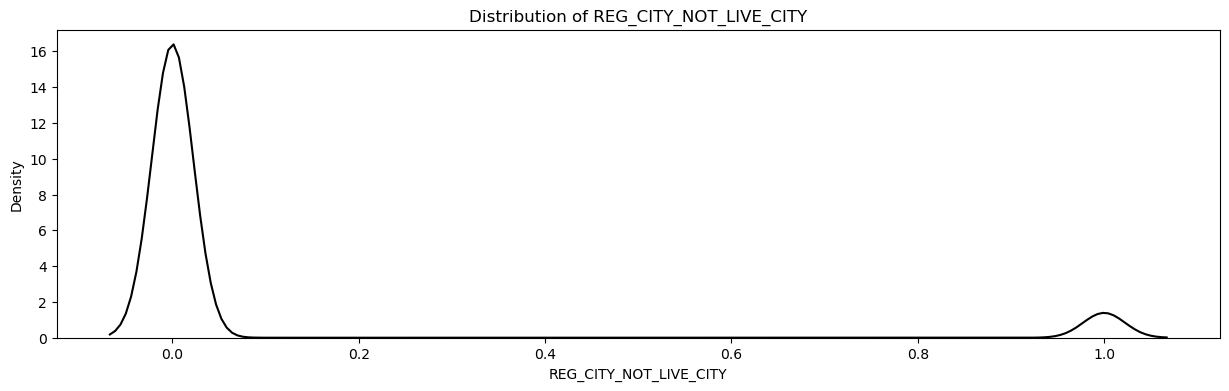

In [65]:
plot_dist('REG_CITY_NOT_LIVE_CITY')

In [66]:
df_temp = woe_num(X_train_prep, 'REG_CITY_NOT_LIVE_CITY', y_train_prep)
df_temp

,REG_CITY_NOT_LIVE_CITY,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,0,246008,226801,0.921925,209278,17523,0.925403,0.882326,0.047667,NaN,0.021688
1,1,246008,19207,0.078075,16870,2337,0.074597,0.117674,-0.455813,0.50348,0.021688


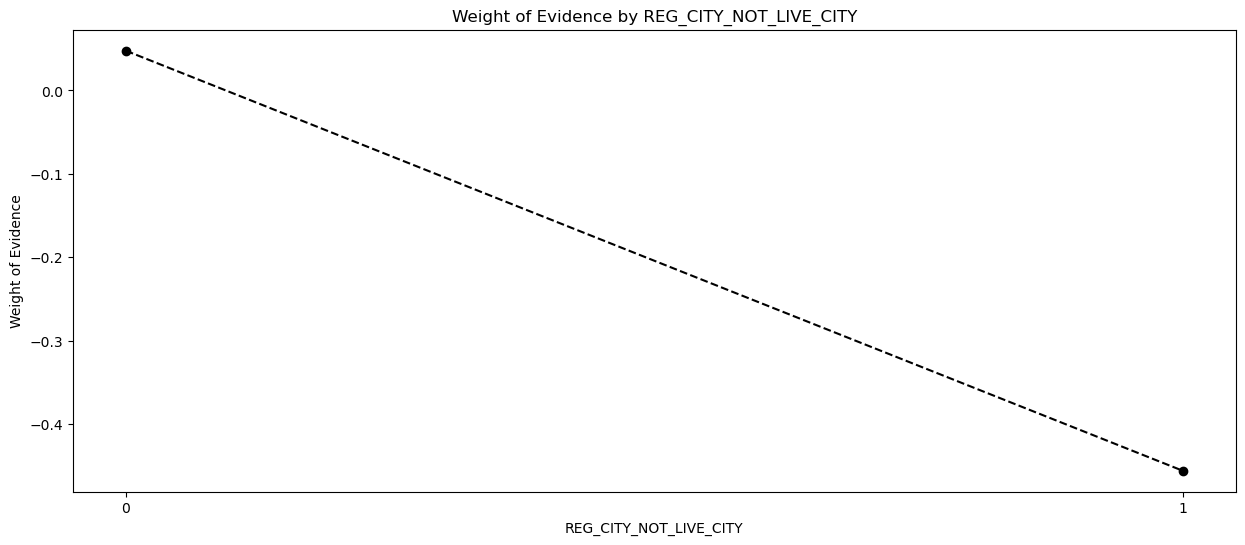

In [67]:
plot_woe(df_temp)

### YEAR_REGISTRATION

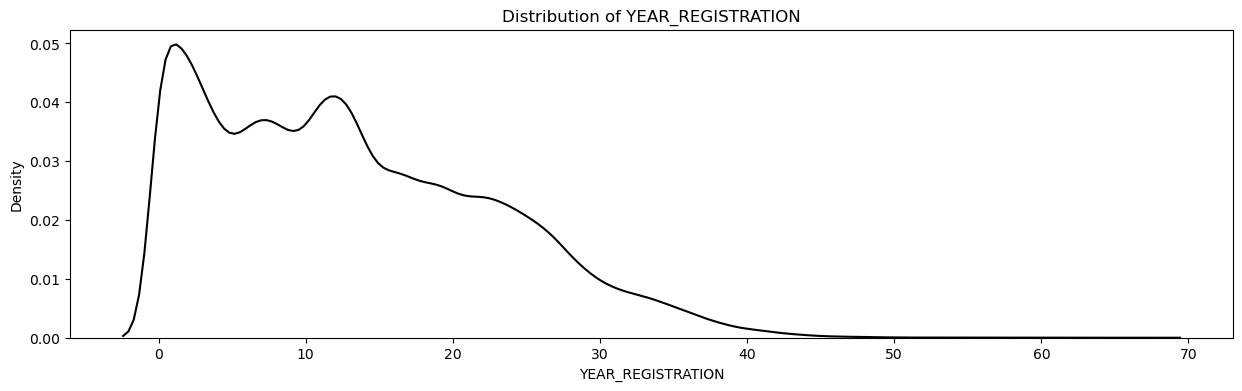

In [68]:
plot_dist('YEAR_REGISTRATION')

In [69]:
X_train_prep['YEAR_REGISTRATION'] = np.where(X_train_prep['YEAR_REGISTRATION'] > 50, 51, X_train_prep['YEAR_REGISTRATION'])
X_train_prep['YEAR_REGISTRATION_class'] = pd.cut(X_train_prep['YEAR_REGISTRATION'], 10)

df_temp = woe_num(X_train_prep, 'YEAR_REGISTRATION', y_train_prep)
df_temp

,YEAR_REGISTRATION,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,0.0,246008,13507,0.054905,12173,1334,0.053828,0.067170,-0.221444,NaN,0.031887
1,1.0,246008,12474,0.050706,11312,1162,0.050020,0.058510,-0.156761,0.064683,0.031887
2,2.0,246008,12009,0.048815,10867,1142,0.048053,0.057503,-0.179532,0.022772,0.031887
3,3.0,246008,10360,0.042112,9472,888,0.041884,0.044713,-0.065358,0.114174,0.031887
4,4.0,246008,8906,0.036202,8181,725,0.036175,0.036506,-0.009084,0.056274,0.031887
5,5.0,246008,8088,0.032877,7383,705,0.032647,0.035498,-0.083744,0.074660,0.031887
6,6.0,246008,8830,0.035893,8040,790,0.035552,0.039778,-0.112331,0.028586,0.031887
7,7.0,246008,9318,0.037877,8496,822,0.037568,0.041390,-0.096872,0.015459,0.031887
8,8.0,246008,9041,0.036751,8286,755,0.036640,0.038016,-0.036877,0.059995,0.031887
9,9.0,246008,8418,0.034218,7659,759,0.033867,0.038218,-0.120847,0.083970,0.031887


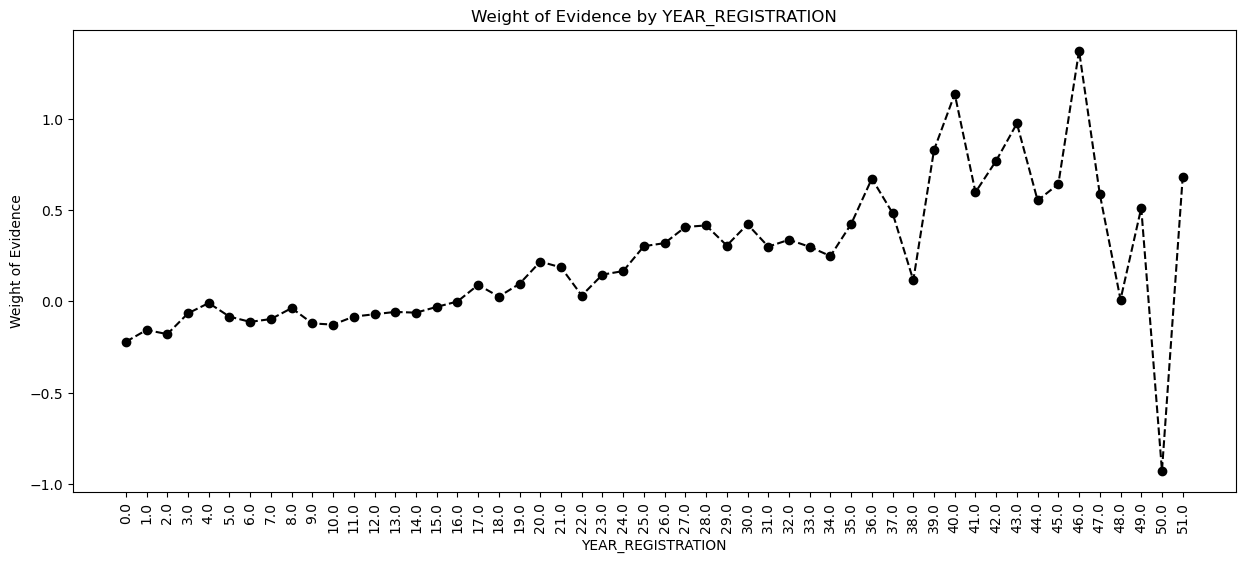

In [70]:
plot_woe(df_temp,90)

### REGION_POPULATION_RELATIVE

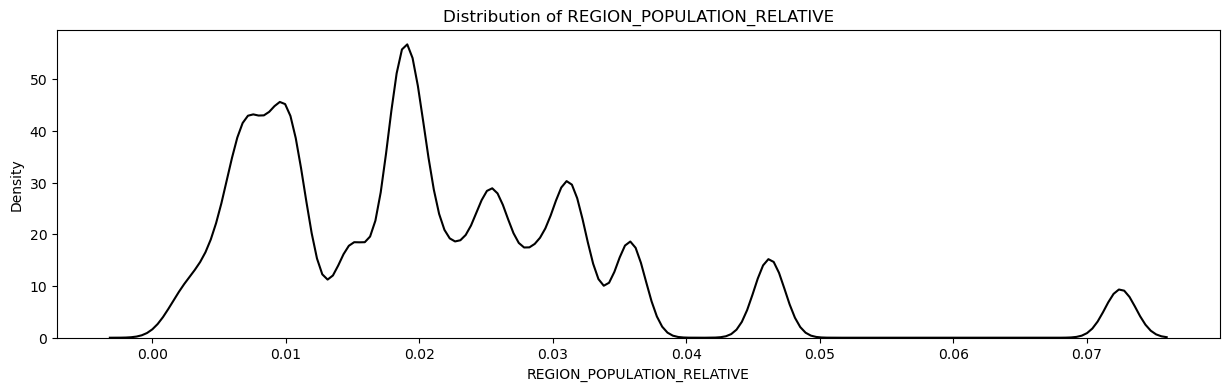

In [71]:
plot_dist('REGION_POPULATION_RELATIVE')

In [72]:
X_train_prep['REGION_POPULATION_RELATIVE_class'] = pd.cut(X_train_prep['REGION_POPULATION_RELATIVE'], 5)

df_temp = woe_num(X_train_prep, 'REGION_POPULATION_RELATIVE_class', y_train_prep)
df_temp

,REGION_POPULATION_RELATIVE_class,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,"(0.000218, 0.0147]",246008,90107,0.366277,82472,7635,0.364682,0.384441,-0.052766,NaN,0.027856
1,"(0.0147, 0.0292]",246008,101099,0.410958,92339,8760,0.408312,0.441088,-0.077211,0.024445,0.027856
2,"(0.0292, 0.0436]",246008,37288,0.151572,34615,2673,0.153063,0.134592,0.128604,0.205815,0.027856
3,"(0.0436, 0.0581]",246008,10842,0.044072,10307,535,0.045576,0.026939,0.525830,0.397226,0.027856
4,"(0.0581, 0.0725]",246008,6672,0.027121,6415,257,0.028366,0.012941,0.784836,0.259006,0.027856


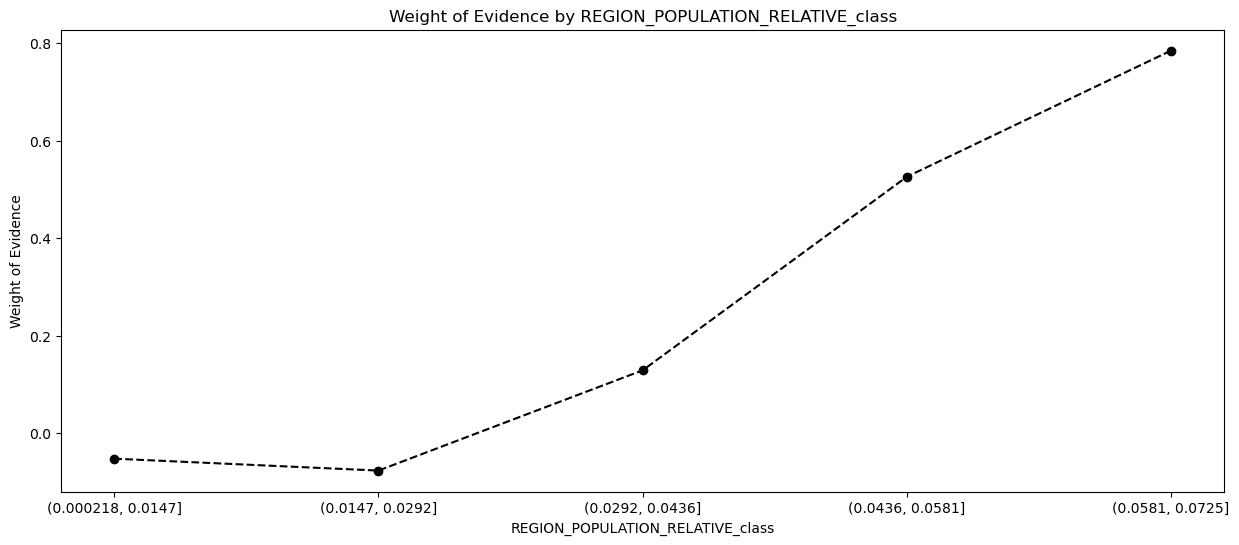

In [73]:
plot_woe(df_temp)

### LIVE_CITY_NOT_WORK_CITY

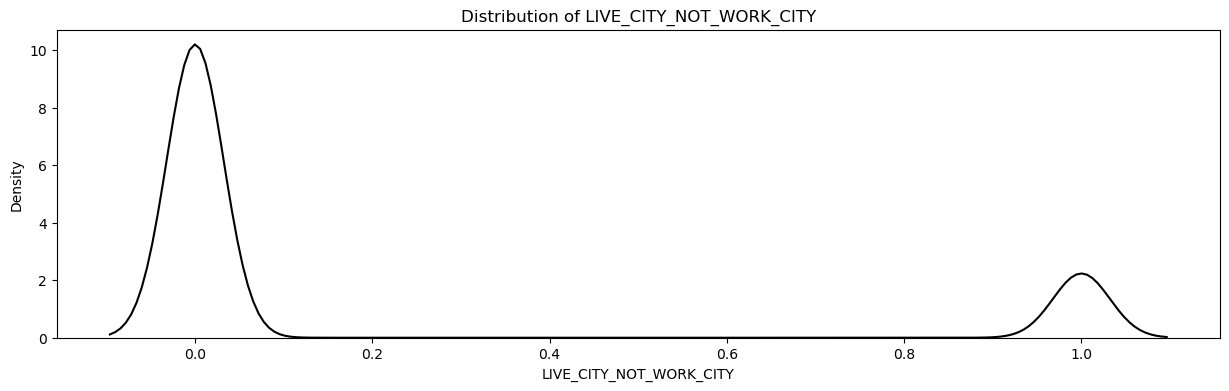

In [74]:
plot_dist('LIVE_CITY_NOT_WORK_CITY')

In [75]:
df_temp = woe_num(X_train_prep, 'LIVE_CITY_NOT_WORK_CITY', y_train_prep)
df_temp

,LIVE_CITY_NOT_WORK_CITY,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,0,246008,201802,0.820307,186345,15457,0.823996,0.778298,0.057056,NaN,0.013156
1,1,246008,44206,0.179693,39803,4403,0.176004,0.221702,-0.230826,0.287882,0.013156


I will not use this column because it has too low IV

### AMT_CREDIT

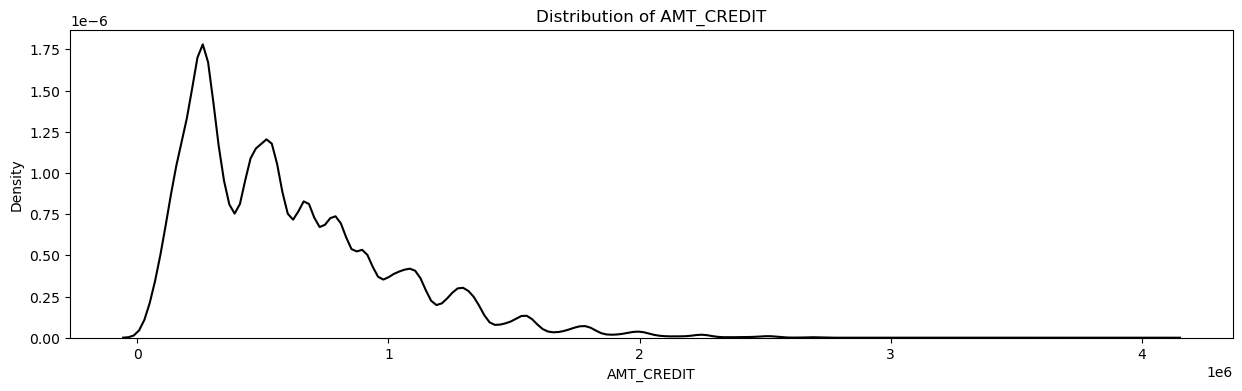

In [76]:
plot_dist('AMT_CREDIT')

In [77]:
X_train_prep['AMT_CREDIT_class'] = pd.cut(X_train_prep['AMT_CREDIT'], 7)

df_temp = woe_num(X_train_prep, 'AMT_CREDIT_class', y_train_prep)
df_temp

,AMT_CREDIT_class,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,"(40995.0, 617142.857]",246008,148677,0.604358,135566,13111,0.599457,0.660171,-0.096475,NaN,0.025162
1,"(617142.857, 1189285.714]",246008,74576,0.303145,69014,5562,0.305172,0.280060,0.085870,0.182345,0.025162
2,"(1189285.714, 1761428.571]",246008,18752,0.076225,17743,1009,0.078457,0.050806,0.434549,0.348680,0.025162
3,"(1761428.571, 2333571.429]",246008,3576,0.014536,3414,162,0.015096,0.008157,0.615562,0.181012,0.025162
4,"(2333571.429, 2905714.286]",246008,392,0.001593,378,14,0.001671,0.000705,0.863355,0.247793,0.025162
5,"(2905714.286, 3477857.143]",246008,22,0.000089,21,1,0.000093,0.000050,0.612040,0.251314,0.025162
6,"(3477857.143, 4050000.0]",246008,13,0.000053,12,1,0.000053,0.000050,0.052425,0.559616,0.025162


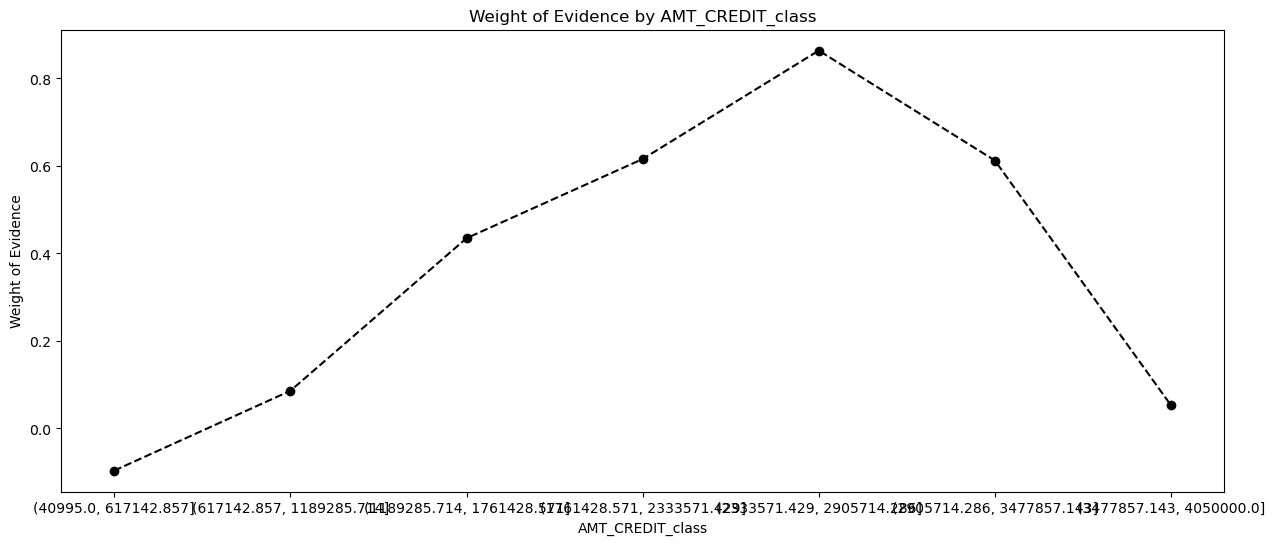

In [78]:
plot_woe(df_temp)

### FLAG_DOCUMENT_6

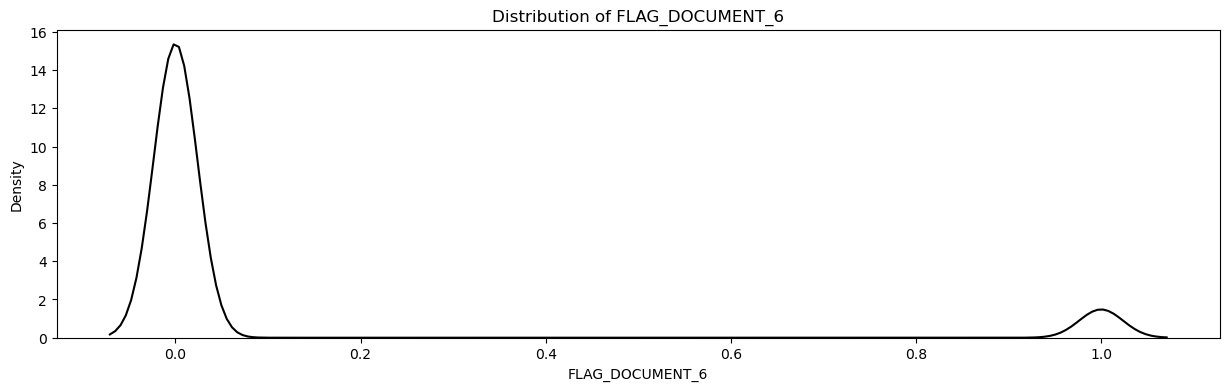

In [79]:
plot_dist('FLAG_DOCUMENT_6')

In [80]:
df_temp = woe_num(X_train_prep, 'FLAG_DOCUMENT_6', y_train_prep)
df_temp

,FLAG_DOCUMENT_6,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,0,246008,224431,0.912291,205748,18683,0.909794,0.940735,-0.033444,NaN,0.014033
1,1,246008,21577,0.087709,20400,1177,0.090206,0.059265,0.420084,0.453528,0.014033


I will not use this column because it has too low IV

### FLAG_WORK_PHONE

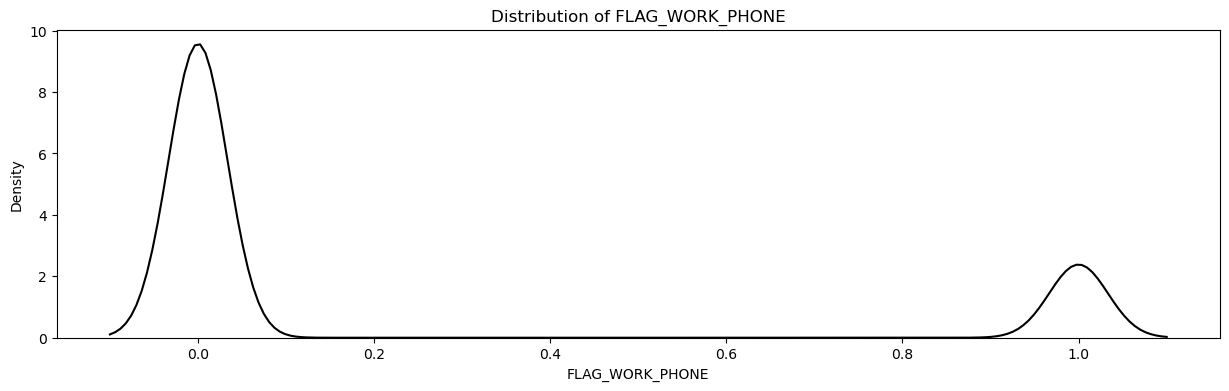

In [81]:
plot_dist('FLAG_WORK_PHONE')

In [82]:
df_temp = woe_num(X_train_prep, 'FLAG_WORK_PHONE', y_train_prep)
df_temp

,FLAG_WORK_PHONE,tot_obs,n_obs,pct_obs,n_good,n_bad,pct_good,pct_bad,WoE,diff_WoE,IV
0,0,246008,196987,0.800734,181866,15121,0.80419,0.76138,0.054704,NaN,0.010807
1,1,246008,49021,0.199266,44282,4739,0.19581,0.23862,-0.197730,0.252434,0.010807


I will not use this column because it has too low IV

Here are the summary of for the WoE and IV:

Not useful for prediction (<0.02): `FLAG_OWN_CAR` `YEAR_EMPLOYED` `LIVE_CITY_NOT_WORK_CITY` `FLAG_DOCUMENT_6` `FLAG_WORK_PHONE` <br>
Weak predictive power (0.02 - 0.1): `CODE_GENDER` `NAME_EDUCATION_TYPE` `NAME_FAMILY_STATUS` `NAME_INCOME_TYPE` `REGION_RATING_CLIENT` `YEAR_BIRTH` `YEAR_LAST_PHONE_CHANGE` `YEAR_ID_PUBLISH` `FLAG_DOCUMENT_3` `REG_CITY_NOT_LIVE_CITY` `YEAR_REGISTRATION` `REGION_POPULATION_RELATIVE` `AMT_CREDIT` <br>
Strong predictive power (0.3 - 0.5): `EXT_SOURCE_2` `EXT_SOURCE_3` <br>

In [83]:
# This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = pd.DataFrame({'CODE_GENDER: M': np.where(X['CODE_GENDER'] == 'M', 1, 0)})
        X_new['CODE_GENDER: F'] = np.where((X['CODE_GENDER'] == 'F') | (X['CODE_GENDER'] == 'XNA'), 1, 0)
        
        X_new['NAME_EDUCATION_TYPE: Lower secondary'] = np.where(X['NAME_EDUCATION_TYPE'] == 'Lower secondary', 1, 0)
        X_new['NAME_EDUCATION_TYPE: Secondary / secondary special'] = np.where(X['NAME_EDUCATION_TYPE'] == 'Secondary / secondary special', 1, 0)
        X_new['NAME_EDUCATION_TYPE: Lower secondary'] = np.where(X['NAME_EDUCATION_TYPE'] == 'Lower secondary', 1, 0)
        X_new['NAME_EDUCATION_TYPE: Incomplete higher'] = np.where(X['NAME_EDUCATION_TYPE'] == 'Incomplete higher', 1, 0)
        X_new['NAME_EDUCATION_TYPE: Academic degree'] = np.where(X['NAME_EDUCATION_TYPE'] == 'Academic degree', 1, 0)
        
        X_new['NAME_FAMILY_STATUS: Civil marriage'] = np.where(X['NAME_FAMILY_STATUS'] == 'Civil marriage', 1, 0)
        X_new['NAME_FAMILY_STATUS: Single / not married'] = np.where(X['NAME_FAMILY_STATUS'] == 'Single / not married', 1, 0)
        X_new['NAME_FAMILY_STATUS: Separated'] = np.where(X['NAME_FAMILY_STATUS'] == 'Separated', 1, 0)
        X_new['NAME_FAMILY_STATUS: Married'] = np.where((X['NAME_FAMILY_STATUS'] == 'Married') | (X['NAME_FAMILY_STATUS'] == 'Unknown'), 1, 0)
        X_new['NAME_FAMILY_STATUS: Widow'] = np.where(X['NAME_FAMILY_STATUS'] == 'Widow', 1, 0)
        
        # These categories have very few observations: Maternity leave, Unemployed, Businessman and Student
        # Businessman has no bad value observation that leads to inf WoE so I will combine it with Commercial associate
        # Student has the same case as Businessman, and because there is no category has a similar meaning to Student.
        # So, I will combine Student, Maternity leave and Unemployed with the nearest WoE value, which is Working
        X_new['NAME_INCOME_TYPE: Work_Unemp_Stud_MaterLeave'] = np.where((X['NAME_INCOME_TYPE'] == 'Working') | (X['NAME_INCOME_TYPE'] == 'Unemployed') | 
                                                                        (X['NAME_INCOME_TYPE'] == 'Maternity leave') | (X['NAME_INCOME_TYPE'] == 'Student'), 1, 0)
        X_new['NAME_INCOME_TYPE: Comm_assoc / Businessman'] = np.where((X['NAME_INCOME_TYPE'] == 'Commercial associate') | (X['NAME_INCOME_TYPE'] == 'Businessman'), 1, 0)
        X_new['NAME_INCOME_TYPE: State servant'] = np.where(X['NAME_INCOME_TYPE'] == 'State servant', 1, 0)
        X_new['NAME_INCOME_TYPE: Pensioner'] = np.where(X['NAME_INCOME_TYPE'] == 'Pensioner', 1, 0)
        
        X_new['EXT_SOURCE_2: missing'] = np.where(X['EXT_SOURCE_2'].isnull(), 1, 0)
        X_new['EXT_SOURCE_2: <0.256'] = np.where(X['EXT_SOURCE_2'] <= 0.256, 1, 0)
        X_new['EXT_SOURCE_2: 0.256-0.427'] = np.where((X['EXT_SOURCE_2'] > 0.256) & (X['EXT_SOURCE_2'] <= 0.427), 1, 0)
        X_new['EXT_SOURCE_2: 0.427-0.513'] = np.where((X['EXT_SOURCE_2'] > 0.427) & (X['EXT_SOURCE_2'] <= 0.513), 1, 0)
        X_new['EXT_SOURCE_2: 0.513-0.598'] = np.where((X['EXT_SOURCE_2'] > 0.513) & (X['EXT_SOURCE_2'] <= 0.598), 1, 0)
        X_new['EXT_SOURCE_2: 0.598-0.684'] = np.where((X['EXT_SOURCE_2'] > 0.598) & (X['EXT_SOURCE_2'] <= 0.684), 1, 0)
        X_new['EXT_SOURCE_2: 0.684-0.769'] = np.where((X['EXT_SOURCE_2'] > 0.684) & (X['EXT_SOURCE_2'] <= 0.769), 1, 0)
        X_new['EXT_SOURCE_2: >0.769'] = np.where(X['EXT_SOURCE_2'] > 0.769, 1, 0)
        
        X_new['EXT_SOURCE_3: missing'] = np.where(X['EXT_SOURCE_3'].isnull(), 1, 0)
        X_new['EXT_SOURCE_3: <0.269'] = np.where(X['EXT_SOURCE_3'] <= 0.269, 1, 0)
        X_new['EXT_SOURCE_3: 0.269-0.359'] = np.where((X['EXT_SOURCE_3'] > 0.269) & (X['EXT_SOURCE_3'] <= 0.359), 1, 0)
        X_new['EXT_SOURCE_3: 0.359-0.448'] = np.where((X['EXT_SOURCE_3'] > 0.359) & (X['EXT_SOURCE_3'] <= 0.448), 1, 0)
        X_new['EXT_SOURCE_3: 0.448-0.538'] = np.where((X['EXT_SOURCE_3'] > 0.448) & (X['EXT_SOURCE_3'] <= 0.538), 1, 0)
        X_new['EXT_SOURCE_3: 0.538-0.627'] = np.where((X['EXT_SOURCE_3'] > 0.538) & (X['EXT_SOURCE_3'] <= 0.627), 1, 0)
        X_new['EXT_SOURCE_3: 0.627-0.717'] = np.where((X['EXT_SOURCE_3'] > 0.627) & (X['EXT_SOURCE_3'] <= 0.717), 1, 0)
        X_new['EXT_SOURCE_3: >0.717'] = np.where(X['EXT_SOURCE_3'] >= 0.717, 1, 0)
        
        X_new['YEAR_BIRTH: <27'] = np.where(X['YEAR_BIRTH'] <= 27, 1, 0)
        X_new['YEAR_BIRTH: 27-34'] = np.where((X['YEAR_BIRTH'] > 27) & (X['YEAR_BIRTH'] <= 34), 1, 0)
        X_new['YEAR_BIRTH: 34-50'] = np.where((X['YEAR_BIRTH'] > 34) & (X['YEAR_BIRTH'] <= 41), 1, 0)
        X_new['YEAR_BIRTH: 41-60'] = np.where((X['YEAR_BIRTH'] > 41) & (X['YEAR_BIRTH'] <= 48), 1, 0)
        X_new['YEAR_BIRTH: 48-50'] = np.where((X['YEAR_BIRTH'] > 48) & (X['YEAR_BIRTH'] <= 55), 1, 0)
        X_new['YEAR_BIRTH: 55-62'] = np.where((X['YEAR_BIRTH'] > 55) & (X['YEAR_BIRTH'] <= 62), 1, 0)
        X_new['YEAR_BIRTH: >60'] = np.where(X['YEAR_BIRTH'] >= 62, 1, 0)
        
        X_new['REGION_RATING_CLIENT: 1'] = np.where(X['REGION_RATING_CLIENT'] == 1, 1, 0)
        X_new['REGION_RATING_CLIENT: 2'] = np.where(X['REGION_RATING_CLIENT'] == 2, 1, 0)
        X_new['REGION_RATING_CLIENT: 3'] = np.where(X['REGION_RATING_CLIENT'] == 3, 1, 0)
        
        X_new['YEAR_LAST_PHONE_CHANGE: <2'] = np.where(X['YEAR_LAST_PHONE_CHANGE'] <= 2, 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE: 2-4'] = np.where((X['YEAR_LAST_PHONE_CHANGE'] > 2) & (X['YEAR_LAST_PHONE_CHANGE'] <= 4), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE: 4-6'] = np.where((X['YEAR_LAST_PHONE_CHANGE'] > 4) & (X['YEAR_LAST_PHONE_CHANGE'] <= 7), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE: >6'] = np.where(X['YEAR_LAST_PHONE_CHANGE'] > 7, 1, 0)
        
        X_new['YEAR_ID_PUBLISH: <5'] = np.where(X['YEAR_ID_PUBLISH'] <= 5, 1, 0)
        X_new['YEAR_ID_PUBLISH: 5-9'] = np.where((X['YEAR_ID_PUBLISH'] > 5) & (X['YEAR_ID_PUBLISH'] <= 9), 1, 0)
        X_new['YEAR_ID_PUBLISH: 9-13'] = np.where((X['YEAR_ID_PUBLISH'] > 9) & (X['YEAR_ID_PUBLISH'] <= 13), 1, 0)
        X_new['YEAR_ID_PUBLISH: >13'] = np.where(X['YEAR_ID_PUBLISH'] > 13, 1, 0)
        
        X_new['FLAG_DOCUMENT_3: 0'] = np.where(X['FLAG_DOCUMENT_3'] == 0, 1, 0)
        X_new['FLAG_DOCUMENT_3: 1'] = np.where(X['FLAG_DOCUMENT_3'] == 1, 1, 0)
        
        X_new['REG_CITY_NOT_LIVE_CITY: 0'] = np.where(X['REG_CITY_NOT_LIVE_CITY'] == 0, 1, 0)
        X_new['REG_CITY_NOT_LIVE_CITY: 1'] = np.where(X['REG_CITY_NOT_LIVE_CITY'] == 1, 1, 0)
        
        X_new['YEAR_REGISTRATION: <8'] = np.where(X['YEAR_REGISTRATION'] <= 8, 1, 0)
        X_new['YEAR_REGISTRATION: 8-17'] = np.where((X['YEAR_REGISTRATION'] > 8) & (X['YEAR_REGISTRATION'] <= 13), 1, 0)
        X_new['YEAR_REGISTRATION: 17-30'] = np.where((X['YEAR_REGISTRATION'] > 13) & (X['YEAR_REGISTRATION'] <= 30), 1, 0)
        X_new['YEAR_REGISTRATION: 30-40'] = np.where((X['YEAR_REGISTRATION'] > 30) & (X['YEAR_REGISTRATION'] <= 40), 1, 0)
        X_new['YEAR_REGISTRATION: >40'] = np.where(X['YEAR_REGISTRATION'] > 40, 1, 0)
        
        X_new['REGION_POPULATION_RELATIVE: <0.0292'] = np.where(X['REGION_POPULATION_RELATIVE'] <= 0.0292, 1, 0)
        X_new['REGION_POPULATION_RELATIVE: 0.0292-0.0436'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0292) & (X['REGION_POPULATION_RELATIVE'] <= 0.0436), 1, 0)
        X_new['REGION_POPULATION_RELATIVE: >0.0436'] = np.where(X['REGION_POPULATION_RELATIVE'] >= 0.0436, 1, 0)
        
        X_new['AMT_CREDIT: <617142'] = np.where(X['AMT_CREDIT'] <= 617142, 1, 0)
        X_new['AMT_CREDIT: 617142-1189285'] = np.where((X['AMT_CREDIT'] > 617142) & (X['AMT_CREDIT'] <= 1189285), 1, 0)
        X_new['AMT_CREDIT: >1189285'] = np.where(X['AMT_CREDIT'] >= 1189285, 1, 0)
        
        return X_new

# PD Model

In [84]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(246008, 20)
(246008,)
(61503, 20)
(61503,)


In [85]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=10)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7292
Gini: 0.4583


The score is not pretty high but it's still good enough

In [86]:
# fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,0.209471
1,CODE_GENDER: M,-0.091653
2,CODE_GENDER: F,0.282240
3,NAME_EDUCATION_TYPE: Lower secondary,-0.609198
4,NAME_EDUCATION_TYPE: Secondary / secondary spe...,-0.440611
...,...,...
60,REGION_POPULATION_RELATIVE: 0.0292-0.0436,0.005562
61,REGION_POPULATION_RELATIVE: >0.0436,0.140353
62,AMT_CREDIT: <617142,0.022610
63,AMT_CREDIT: 617142-1189285,0.016914


# Prediction

In [87]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(61503, 2)

In [88]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
56858,1,0.699237
246501,0,0.447113
55711,1,0.509448
18287,1,0.733107
18188,1,0.420740


# Confusion Matrix and AUROC on Test Set

In [89]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.05376973, 0.02695803],
       [0.29940003, 0.6198722 ]])

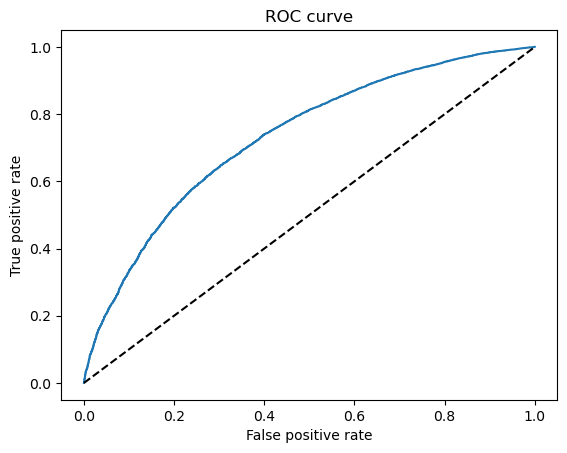

In [90]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [91]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.7318090708681098

In [92]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.4636181417362195

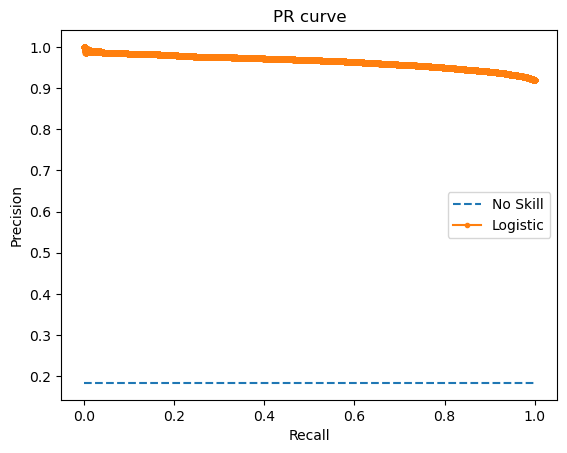

In [93]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [94]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.9646377757164317

# Applying the Model - Scorecard Creation

In [95]:
pd.options.display.max_rows = 65
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard = summary_table
# summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
df_scorecard.insert(1, 'Original feature name', df_scorecard['Feature name'].str.split(': ').str[0],)
df_scorecard

,Feature name,Original feature name,Coefficients
0,Intercept,Intercept,0.209471
1,CODE_GENDER: M,CODE_GENDER,-0.091653
2,CODE_GENDER: F,CODE_GENDER,0.282240
3,NAME_EDUCATION_TYPE: Lower secondary,NAME_EDUCATION_TYPE,-0.609198
4,NAME_EDUCATION_TYPE: Secondary / secondary spe...,NAME_EDUCATION_TYPE,-0.440611
5,NAME_EDUCATION_TYPE: Incomplete higher,NAME_EDUCATION_TYPE,-0.202266
6,NAME_EDUCATION_TYPE: Academic degree,NAME_EDUCATION_TYPE,0.960942
7,NAME_FAMILY_STATUS: Civil marriage,NAME_FAMILY_STATUS,-0.051236
8,NAME_FAMILY_STATUS: Single / not married,NAME_FAMILY_STATUS,-0.006237
9,NAME_FAMILY_STATUS: Separated,NAME_FAMILY_STATUS,-0.034647


In [96]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [97]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,Feature name,Original feature name,Coefficients,Score - Calculation,Score - Preliminary
0,Intercept,Intercept,0.209471,532.918506,533.0
1,CODE_GENDER: M,CODE_GENDER,-0.091653,-6.406742,-6.0
2,CODE_GENDER: F,CODE_GENDER,0.282240,19.729201,20.0
3,NAME_EDUCATION_TYPE: Lower secondary,NAME_EDUCATION_TYPE,-0.609198,-42.584304,-43.0
4,NAME_EDUCATION_TYPE: Secondary / secondary spe...,NAME_EDUCATION_TYPE,-0.440611,-30.799710,-31.0
5,NAME_EDUCATION_TYPE: Incomplete higher,NAME_EDUCATION_TYPE,-0.202266,-14.138841,-14.0
6,NAME_EDUCATION_TYPE: Academic degree,NAME_EDUCATION_TYPE,0.960942,67.172012,67.0
7,NAME_FAMILY_STATUS: Civil marriage,NAME_FAMILY_STATUS,-0.051236,-3.581528,-4.0
8,NAME_FAMILY_STATUS: Single / not married,NAME_FAMILY_STATUS,-0.006237,-0.435963,-0.0
9,NAME_FAMILY_STATUS: Separated,NAME_FAMILY_STATUS,-0.034647,-2.421925,-2.0


In [98]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
852.0


In [99]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,Feature name,Original feature name,Coefficients,Score - Calculation,Score - Preliminary,Difference
0,Intercept,Intercept,0.209471,532.918506,533.0,0.081494
1,CODE_GENDER: M,CODE_GENDER,-0.091653,-6.406742,-6.0,0.406742
2,CODE_GENDER: F,CODE_GENDER,0.282240,19.729201,20.0,0.270799
3,NAME_EDUCATION_TYPE: Lower secondary,NAME_EDUCATION_TYPE,-0.609198,-42.584304,-43.0,-0.415696
4,NAME_EDUCATION_TYPE: Secondary / secondary spe...,NAME_EDUCATION_TYPE,-0.440611,-30.799710,-31.0,-0.200290
5,NAME_EDUCATION_TYPE: Incomplete higher,NAME_EDUCATION_TYPE,-0.202266,-14.138841,-14.0,0.138841
6,NAME_EDUCATION_TYPE: Academic degree,NAME_EDUCATION_TYPE,0.960942,67.172012,67.0,-0.172012
7,NAME_FAMILY_STATUS: Civil marriage,NAME_FAMILY_STATUS,-0.051236,-3.581528,-4.0,-0.418472
8,NAME_FAMILY_STATUS: Single / not married,NAME_FAMILY_STATUS,-0.006237,-0.435963,-0.0,0.435963
9,NAME_FAMILY_STATUS: Separated,NAME_FAMILY_STATUS,-0.034647,-2.421925,-2.0,0.421925


In [100]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[52, 'Score - Final'] = 14 # deducting 1 from the REG_CITY_NOT_LIVE_CITY: 0 column
df_scorecard.loc[64, 'Score - Final'] = 10 # deducting 1 from the AMT_CREDIT: >1189285 column
df_scorecard

,Feature name,Original feature name,Coefficients,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,Intercept,0.209471,532.918506,533.0,0.081494,533.0
1,CODE_GENDER: M,CODE_GENDER,-0.091653,-6.406742,-6.0,0.406742,-6.0
2,CODE_GENDER: F,CODE_GENDER,0.282240,19.729201,20.0,0.270799,20.0
3,NAME_EDUCATION_TYPE: Lower secondary,NAME_EDUCATION_TYPE,-0.609198,-42.584304,-43.0,-0.415696,-43.0
4,NAME_EDUCATION_TYPE: Secondary / secondary spe...,NAME_EDUCATION_TYPE,-0.440611,-30.799710,-31.0,-0.200290,-31.0
5,NAME_EDUCATION_TYPE: Incomplete higher,NAME_EDUCATION_TYPE,-0.202266,-14.138841,-14.0,0.138841,-14.0
6,NAME_EDUCATION_TYPE: Academic degree,NAME_EDUCATION_TYPE,0.960942,67.172012,67.0,-0.172012,67.0
7,NAME_FAMILY_STATUS: Civil marriage,NAME_FAMILY_STATUS,-0.051236,-3.581528,-4.0,-0.418472,-4.0
8,NAME_FAMILY_STATUS: Single / not married,NAME_FAMILY_STATUS,-0.006237,-0.435963,-0.0,0.435963,-0.0
9,NAME_FAMILY_STATUS: Separated,NAME_FAMILY_STATUS,-0.034647,-2.421925,-2.0,0.421925,-2.0


In [101]:
# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

300.0
850.0


# Calculating credit scores for all observations in the test data set

In [102]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,CODE_GENDER: M,CODE_GENDER: F,NAME_EDUCATION_TYPE: Lower secondary,NAME_EDUCATION_TYPE: Secondary / secondary special,NAME_EDUCATION_TYPE: Incomplete higher,NAME_EDUCATION_TYPE: Academic degree,NAME_FAMILY_STATUS: Civil marriage,NAME_FAMILY_STATUS: Single / not married,NAME_FAMILY_STATUS: Separated,NAME_FAMILY_STATUS: Married,NAME_FAMILY_STATUS: Widow,NAME_INCOME_TYPE: Work_Unemp_Stud_MaterLeave,NAME_INCOME_TYPE: Comm_assoc / Businessman,NAME_INCOME_TYPE: State servant,NAME_INCOME_TYPE: Pensioner,EXT_SOURCE_2: missing,EXT_SOURCE_2: <0.256,EXT_SOURCE_2: 0.256-0.427,EXT_SOURCE_2: 0.427-0.513,EXT_SOURCE_2: 0.513-0.598,EXT_SOURCE_2: 0.598-0.684,EXT_SOURCE_2: 0.684-0.769,EXT_SOURCE_2: >0.769,EXT_SOURCE_3: missing,EXT_SOURCE_3: <0.269,EXT_SOURCE_3: 0.269-0.359,EXT_SOURCE_3: 0.359-0.448,EXT_SOURCE_3: 0.448-0.538,EXT_SOURCE_3: 0.538-0.627,EXT_SOURCE_3: 0.627-0.717,EXT_SOURCE_3: >0.717,YEAR_BIRTH: <27,YEAR_BIRTH: 27-34,YEAR_BIRTH: 34-50,YEAR_BIRTH: 41-60,YEAR_BIRTH: 48-50,YEAR_BIRTH: 55-62,YEAR_BIRTH: >60,REGION_RATING_CLIENT: 1,REGION_RATING_CLIENT: 2,REGION_RATING_CLIENT: 3,YEAR_LAST_PHONE_CHANGE: <2,YEAR_LAST_PHONE_CHANGE: 2-4,YEAR_LAST_PHONE_CHANGE: 4-6,YEAR_LAST_PHONE_CHANGE: >6,YEAR_ID_PUBLISH: <5,YEAR_ID_PUBLISH: 5-9,YEAR_ID_PUBLISH: 9-13,YEAR_ID_PUBLISH: >13,FLAG_DOCUMENT_3: 0,FLAG_DOCUMENT_3: 1,REG_CITY_NOT_LIVE_CITY: 0,REG_CITY_NOT_LIVE_CITY: 1,YEAR_REGISTRATION: <8,YEAR_REGISTRATION: 8-17,YEAR_REGISTRATION: 17-30,YEAR_REGISTRATION: 30-40,YEAR_REGISTRATION: >40,REGION_POPULATION_RELATIVE: <0.0292,REGION_POPULATION_RELATIVE: 0.0292-0.0436,REGION_POPULATION_RELATIVE: >0.0436,AMT_CREDIT: <617142,AMT_CREDIT: 617142-1189285,AMT_CREDIT: >1189285
0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0
2,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0
3,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0
4,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0


In [103]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final'].values.reshape(65, 1)#.to_list()#.to_frame().to_numpy()
# scorecard_scores = scorecard_scores.values.reshape(102, 1)
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(61503, 65)
(65, 1)


In [104]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
0,578.0
1,503.0
2,522.0
3,590.0
4,497.0


# Setting loan approval cut-offs

In [105]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.301398


Best Threshold: 0.301398

This means that based on the Youden's J statistic, the ideal probability threshold is 0.301398 which minimizes the FPR and maximimizes the TPR - all samples with a predicted probability higher than this should be classified as in Default and vice versa. At first, this ideal threshold appears to be counterintuitive compared to the default probability threshold of 0.5. But remember that we used the class_weight parameter when fitting our logistic regression model that would have helped us.

We can confirm this by looking at our original confusion matrix with the updated threshold

In [106]:
# update the threshold value
tr = best_thresh
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.02499065, 0.05573712],
       [0.07715071, 0.84212152]])

In [107]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()

,thresholds,Score
0,0.051878,315.0
1,0.064796,332.0
2,0.067576,335.0
3,0.067981,335.0
4,0.069897,337.0


In [108]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [109]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.051878,315.0,61503,0,1.000000,0.000000
1,0.064796,332.0,61502,1,0.999984,0.000016
2,0.067576,335.0,61501,2,0.999967,0.000033
3,0.067981,335.0,61499,4,0.999935,0.000065
4,0.069897,337.0,61498,5,0.999919,0.000081


In [110]:
best_thresh

0.30139814915944996

In [111]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.30139, 0.30141)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5726,0.301398,460.0,55222,6281,0.897875,0.102125
5727,0.301407,460.0,55221,6282,0.897859,0.102141


In [112]:
# compare the above rates with the case of the default 0.5 threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.5, 0.50003)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
20040,0.500023,518.0,39782,21721,0.64683,0.35317


0.5 threshold would result in a very high rejection rate with a corresponding loss of business.

Accordingly, we will stick with our ideal threshold and the corresponding Creidt Score of 488, and will monitor the model's performance in production

In [113]:
scorecard_final = df_scorecard[['Original feature name', 'Score - Final']].copy()
scorecard_final.insert(1, 'Category', df_scorecard['Feature name'].apply(lambda x: x.split(":")[1] if x != 'Intercept' else 'Intercept'))
scorecard_final

,Original feature name,Category,Score - Final
0,Intercept,Intercept,533.0
1,CODE_GENDER,M,-6.0
2,CODE_GENDER,F,20.0
3,NAME_EDUCATION_TYPE,Lower secondary,-43.0
4,NAME_EDUCATION_TYPE,Secondary / secondary special,-31.0
5,NAME_EDUCATION_TYPE,Incomplete higher,-14.0
6,NAME_EDUCATION_TYPE,Academic degree,67.0
7,NAME_FAMILY_STATUS,Civil marriage,-4.0
8,NAME_FAMILY_STATUS,Single / not married,-0.0
9,NAME_FAMILY_STATUS,Separated,-2.0
